### Development of a score based on the gaussian heatmaps 
This can be used to generate the 'ground truth' score of the heatmaps produced from the Contextual layer , which will be compared with the score produced from the FCN heatmaps layer. 

- First we generate the heatmaps, and also visually cehck them. 
- the we pass the heatmaps to the routine that prodcues the scores 


## Build MRCNN model

In [9]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, math, io, time, gc, argparse, platform, pprint, pickle, copy
import numpy as np
import tensorflow as tf
import keras
import keras.backend as KB
sys.path.append('../')
import numpy as np
import mrcnn.utils     as utils
import mrcnn.visualize as visualize
import mrcnn.visualize_2 as vis2 
import mrcnn.prep_notebook as prep

from mrcnn.visualize     import display_training_batch
from mrcnn.newshapes     import prep_newshape_dataset
from mrcnn.utils         import trim_zeros, compute_overlaps

from datetime            import datetime   
from mrcnn.utils         import command_line_parser, Paths
from mrcnn.coco          import prep_coco_dataset
from mrcnn.prep_notebook import build_fcn_inference_pipeline,run_fcn_inference_pipeline 
from mrcnn.prep_notebook import run_full_inference_pipeline, run_mrcnn_inference_pipeline, run_fcn_inference_pipeline   ###run_pipeline_on_input

pp = pprint.PrettyPrinter(indent=2, width=100)
float_formatter = lambda x: "%10.4f" % x
np_format = {}
np_format['float']=float_formatter
# np.set_printoptions(linewidth=150, precision=3, floatmode='fixed', threshold =10000, formatter = np_format)  
np.set_printoptions(linewidth=190, precision=4, threshold=10000, suppress = True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# WEIGHT_FILE = " F:/models/train_fcn8_coco_adam/fcn20181109T0000/fcn_1569.h5"
# WEIGHT_FILE = " F:/models/train_fcn8_coco_adam/fcn20181109T0000/fcn_1569.h5"
WEIGHT_FILE = " last"

##------------------------------------------------------------------------------------
## Parse command line arguments
##------------------------------------------------------------------------------------
parser = command_line_parser()
input_parms  =" --batch_size 1 "
input_parms +=" --mrcnn_logs_dir train_mrcnn_newshapes "
input_parms +=" --fcn_logs_dir   train_fcn8L2_BCE "
input_parms +=" --mrcnn_model    last "
input_parms +=" --fcn_model      last "    ##  + WEIGHT_FILE    
input_parms +=" --opt            adam "
input_parms +=" --fcn_arch       fcn8L2 " 
input_parms +=" --fcn_layers     all " 
input_parms +=" --sysout        screen "
input_parms +=" --scale_factor 1"
# input_parms +=" --coco_classes   62 63 67 78 79 80 81 82 72 73 74 75 76 77 "
# input_parms +=" --coco_classes   78 79 80 81 82 44 46 47 48 49 50 51 34 35 36 37 38 39 40 41 42 43 10 11 13 14 15 "
# input_parms +=" --new_log_folder    "
print(input_parms)

args = parser.parse_args(input_parms.split())
utils.display_input_parms(args)

 --batch_size 1  --mrcnn_logs_dir train_mrcnn_newshapes  --fcn_logs_dir   train_fcn8L2_BCE  --mrcnn_model    last  --fcn_model      last  --opt            adam  --fcn_arch       fcn8L2  --fcn_layers     all  --sysout        screen  --scale_factor 1

   Arguments passed :
   --------------------
   batch_size                     1
   coco_classes                   None
   epochs                         1
   evaluate_method                1
   fcn_arch                       FCN8L2
   fcn_bce_loss_class             0
   fcn_bce_loss_method            1
   fcn_layers                     ['all']
   fcn_logs_dir                   train_fcn8L2_BCE
   fcn_losses                     fcn_BCE_loss
   fcn_model                      last
   last_epoch                     0
   lr                             0.001
   mrcnn_exclude_layers           None
   mrcnn_layers                   ['mrcnn', 'fpn', 'rpn']
   mrcnn_logs_dir                 train_mrcnn_newshapes
   mrcnn_model                    la

In [3]:
mrcnn_model, fcn_model = prep.build_fcn_inference_pipeline_newshapes(args = args, verbose = 0)

MODE IS: inference

--> Execution started at: 02-11-2019 @ 10:59:25
    Tensorflow Version: 1.8.0   Keras Version : 2.1.6 
    Build_mrcnn_inference_pipeline_newshapes MODE is : inference

   Arguments passed :
   --------------------
   batch_size                     1
   coco_classes                   None
   epochs                         1
   evaluate_method                1
   fcn_arch                       FCN8L2
   fcn_bce_loss_class             0
   fcn_bce_loss_method            1
   fcn_layers                     ['all']
   fcn_logs_dir                   train_fcn8L2_BCE
   fcn_losses                     fcn_BCE_loss
   fcn_model                      last
   last_epoch                     0
   lr                             0.001
   mrcnn_exclude_layers           None
   mrcnn_layers                   ['mrcnn', 'fpn', 'rpn']
   mrcnn_logs_dir                 train_mrcnn_newshapes
   mrcnn_model                    last
   new_log_folder                 False
   opt            

    Weights file loaded: /home/kbardool/models_newshapes/train_mrcnn_newshapes/mrcnn20181216T0000/mrcnn_0472.h5 
MRCNN  MODEL Load weight file COMPLETE 
>>> Initialize Paths
 Linx  Linux
>>> Initialize ModelBase model 
   Mode      :  inference
   Model dir :  /home/kbardool/models_newshapes/train_fcn8L2_BCE
>>> ModelBase initialiation complete
>>> Initialize FCN model, mode:  inference architecture:  FCN8L2
    arch set to FCN8 - with L2 Regularization
<function fcn8_l2_graph at 0x7fd9917f98c8>


---------------------------------------------------
 Build FCN Model -  Arch:  FCN8L2  mode:  inference
---------------------------------------------------

------------------------------------------------------
>>> FCN8L2 Layer With Regularization - mode: inference
------------------------------------------------------

 
---------------------------------------------
>>> FCN Scoring Graph  - mode: inference
---------------------------------------------

 
------------------------------------

## Build Training & Validation Datasets

### Coco

In [3]:
load_class_ids = args.coco_classes
print('load coco classes: ', load_class_ids)

dataset_train, train_generator= prep_coco_dataset(['train', 'val35k'], fcn_model.config, generator = True,shuffle = False, load_coco_classes=load_class_ids)
# dataset_val, val_generator    = prep_coco_dataset(['minival'], fcn_config, generator = True, shuffle = False)
# dataset_test.display_class_info()
dataset_train.display_active_class_info()
print("Testing Dataset Image Count: {}".format(len(dataset_train.image_ids)))
print("Testing Dataset Class Count: {}".format(dataset_train.num_classes))
class_names = dataset_train.class_names


load coco classes:  [78, 79, 80, 81, 82, 44, 46, 47, 48, 49, 50, 51, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 10, 11, 13, 14, 15]
COCO loading annotations file F:\MLDatasets\coco2014\annotations/instances_train2014.json  into memory...
Done (t=19.10s)
creating index...
index created!
 load subset of classes:  [78, 79, 80, 81, 82, 44, 46, 47, 48, 49, 50, 51, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 10, 11, 13, 14, 15]
 image dir            :  F:\MLDatasets\coco2014\train2014
 json_path_dir        :  F:\MLDatasets\coco2014\annotations/instances_train2014.json
 number of images     :  40400
 image_ids[:10]       :  [262146, 524291, 9, 393227, 393230, 131087, 393241, 393242, 131099, 393251]
 image_ids[1000:1010] :  [396150, 265080, 396157, 2951, 396172, 134032, 134033, 527250, 2963, 2964]
COCO loading annotations file F:\MLDatasets\coco2014\annotations/instances_valminusminival2014.json  into memory...
Done (t=8.84s)
creating index...
index created!
 load subset of classes:  [78, 79, 80, 81,

### Newshapes

In [6]:
# del dataset_train, dataset_val, train_generator, val_generator
# dataset_test , test_generator   = prep_newshape_dataset( mrcnn_model.config,  1000, generator=True)
# with open('newshapes_dataset_1000_B.pkl', 'wb') as outfile:
#     pickle.dump(dataset_test, outfile)
## -- OR --

# with open("E:\\git_projs\\MRCNN3\\train_newshapes\\newshapes_test_dataset_1000.pkl", 'rb') as infile:
# with open("E:\\git_projs\\MRCNN3\\train_newshapes\\newshapes_test_dataset_1000_B.pkl", 'rb') as infile:
with open("/home/kbardool/mrcnn3/train_newshapes/newshapes_test_dataset_1000_B.pkl", 'rb') as infile:
    
    dataset_test = pickle.load(infile)

In [7]:
dataset_test.display_active_class_info()
print("Testing Dataset Image Count: {}".format(len(dataset_test.image_ids)))
print("Testing Dataset Class Count: {}".format(dataset_test.num_classes))
print(len(dataset_test.image_ids))    
class_names = dataset_test.class_names

[1, 2, 3, 4, 5, 6]
internal_class:  1 ext_cls: 1 name: None - person
internal_class:  2 ext_cls: 2 name: None - car
internal_class:  3 ext_cls: 3 name: None - sun
internal_class:  4 ext_cls: 4 name: None - building
internal_class:  5 ext_cls: 5 name: None - tree
internal_class:  6 ext_cls: 6 name: None - cloud
Testing Dataset Image Count: 1000
Testing Dataset Class Count: 7
1000


## Display Images

###  Display some images from dataset

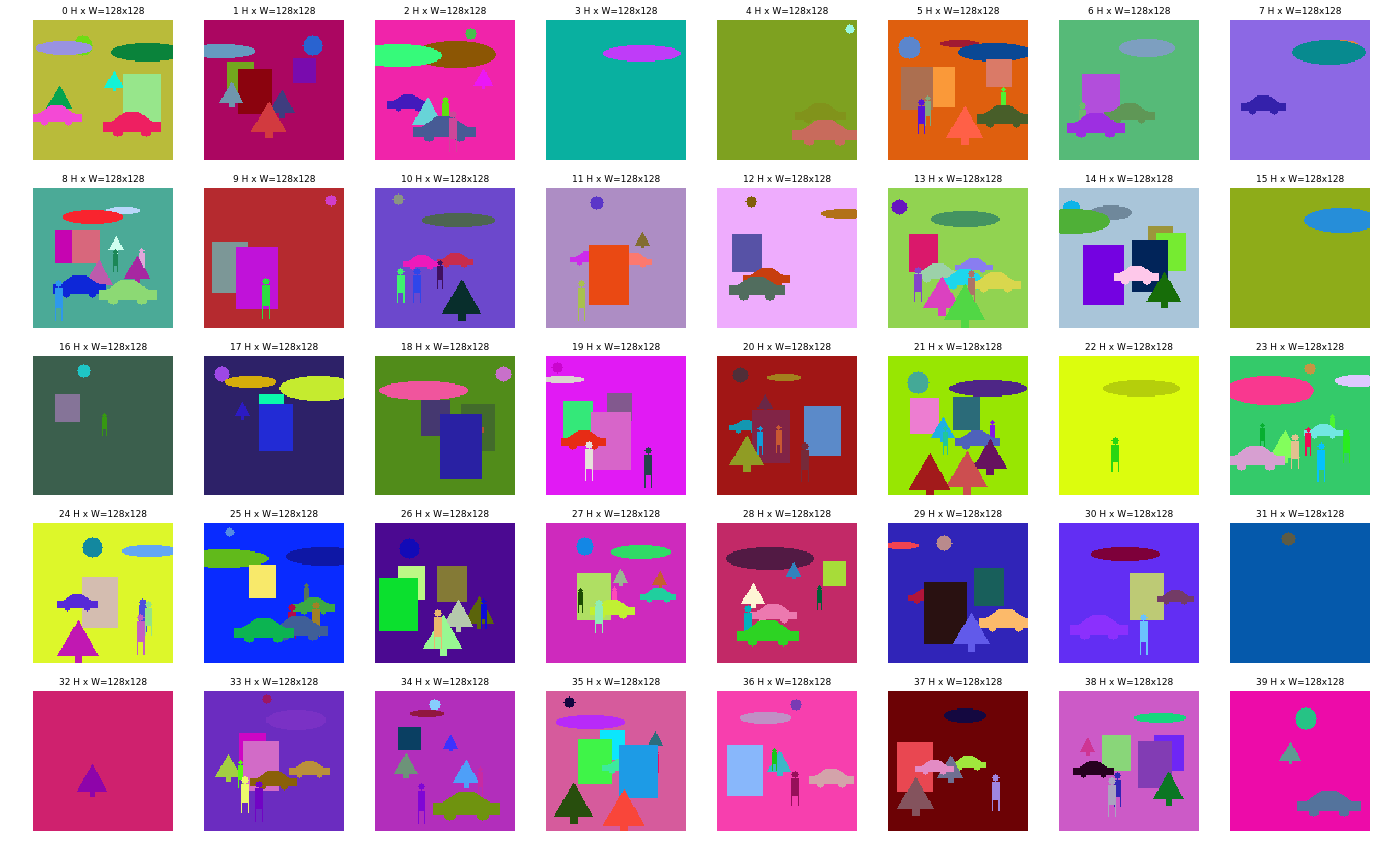

In [8]:
image_list = list(range(0,40))
image_titles = [str(i) for i in image_list]
images = prep.get_image_batch(dataset_test, image_list)
visualize.display_images(images, titles = image_titles, cols = 8, width = 24)

###  Display image with Ground Truth bounding boxes and masks

In [ ]:
# train_batch_x, train_batch_y = next(train_generator)
# visualize.display_training_batch(dataset_train, train_batch_x)

In [ ]:
# IMAGE_LIST = train_batch_x[1][:,0]
# print('IMAGE_LIST : ', IMAGE_LIST)
# for image_id in IMAGE_LIST:
#     print()
#     print('IMAGE_ID : ', image_id)#### Load a specific image using image_id
#     annotations = dataset_train.image_info[image_id]["annotations"]
# #     print(annotations)
#     for annotation in annotations:
#         class_id = dataset_train.map_source_class_id( "coco.{}".format(annotation['category_id']))
#         print("coco.id: {} --> class_id : {}  - {} ".format(annotation['category_id'],class_id, dataset_train.class_names[class_id]))

### Load a specific image using image_id

Processing 1 images
image                    shape: (427, 640, 3)         min:    0.00000  max:  246.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  142.10001
image_metas              shape: (1, 89)               min:    0.00000  max: 7143.00000
 Image_id    :  7143  Reference:  http://cocodataset.org/#explore?id=20818 Coco Id: 20818
 Image meta  :  [7143  427  640    3  170    0  853 1024]
 Class ids   :  (3,)    [55 55 42]
 Class Names :  ['donut', 'donut', 'cup']


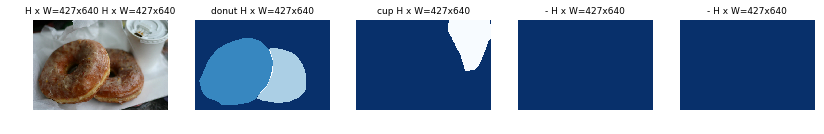

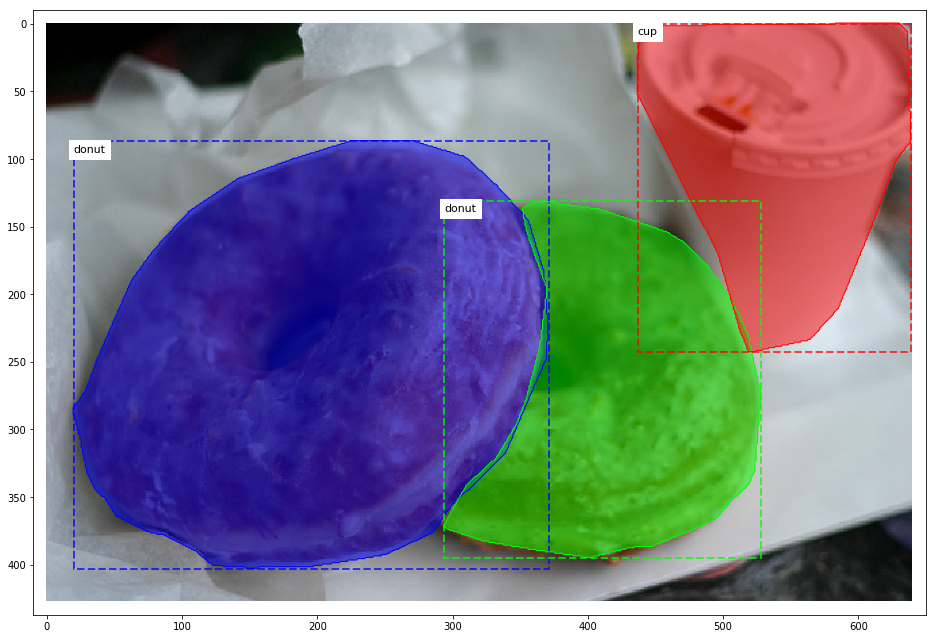

In [4]:
# train_batch_x, _ =  data_gen_simulate(dataset_train, mrcnn_model.config, [7143]) ## [1234])
# visualize.display_training_batch(dataset_train, train_batch_x)

batch_x = get_inference_batch(dataset_train, mrcnn_model.config, image_ids = 7143, display = True)

## Pass data through MRCNN-FCN `inference` pipeline

Processing 1 images
image                    shape: (128, 128, 3)         min:    3.00000  max:  255.00000
molded_images            shape: (1, 128, 128, 3)      min: -104.70000  max:  131.30000
image_metas              shape: (1, 15)               min:    0.00000  max:  128.00000
image id :  27
 Image_id    :  27  Reference:  [('sun', (19, 135, 229), (35, 21, 8, 8)), ('cloud', (48, 219, 102), (86, 26, 27, 6)), ('tree', (154, 183, 146), (68, 48, 9, 9)), ('tree', (198, 93, 47), (104, 50, 9, 9)), ('car', (32, 207, 158), (102, 67, 16, 8)), ('building', (175, 223, 99), (43, 67, 15, 21)), ('person', (255, 74, 185), (62, 71, 2, 11)), ('person', (27, 75, 3), (31, 72, 2, 11)), ('car', (193, 240, 51), (60, 80, 20, 10)), ('person', (143, 237, 181), (48, 88, 3, 15))] Coco Id: 27
 Image meta  :  [ 27 128 128   3   0   0 128 128]
 Class ids   :  (10,)    [3 6 5 5 2 4 1 1 2 1]
 Class Names :  ['sun', 'cloud', 'tree', 'tree', 'car', 'building', 'person', 'person', 'car', 'person']


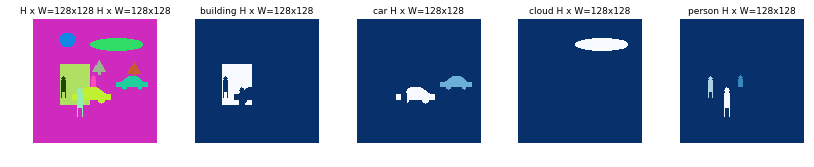

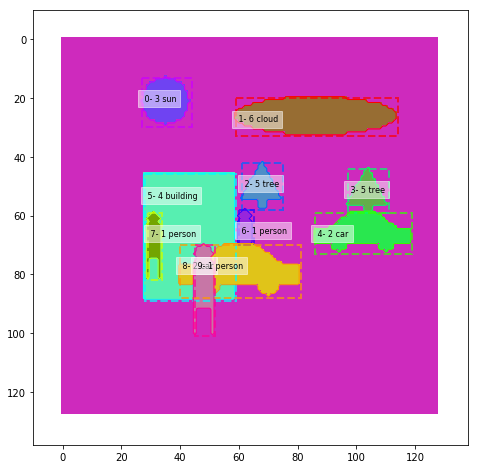

In [46]:
# train_batch_x, _ =  data_gen_simulate(dataset_train, mrcnn_model.config, [7143]) ## [1234])
# visualize.display_training_batch(dataset_train, train_batch_x)

batch_x = prep.get_inference_batch(dataset_test, mrcnn_model.config, image_ids = 27,display = True)

####  `run_mrcnn_training_pipeline()`

In [33]:
# outputs = run_mrcnn_inference_pipeline(mrcnn_model, dataset_train, batch_x, verbose= 1)
# del fcn_outputs
fcn_results = run_full_inference_pipeline(mrcnn_model, fcn_model, dataset_test, batch_x, verbose= 1)

** Pass through MRCNN model:
/* Inputs */
Input  0:  (input_image:0                           ) 	  Input shape: (1, 128, 128, 3)
Input  1:  (input_image_meta:0                      ) 	  Input shape: (1, 15)

Requested layers:
-----------------
Layer   0:  (mrcnn_detection/detections:0            ) 	  Output shape: <unknown>
Layer   1:  (ROI/rpn_roi_proposals:0                 ) 	  Output shape: (1, ?, ?)
Layer   2:  (mrcnn_class_lambda/mrcnn_class:0        ) 	  Output shape: (?, 1000, 7)
Layer   3:  (mrcnn_bbox_lambda/mrcnn_bbox:0          ) 	  Output shape: (?, 1000, 7, 4)
Layer   4:  (cntxt_layer/pred_heatmap:0              ) 	  Output shape: (1, 128, 128, 7)
Layer   5:  (cntxt_layer/pred_heatmap_scores:0       ) 	  Output shape: (1, 7, 64, 24)

/* Outputs */
Output idx:  0    Layer:  0: (mrcnn_detection/detections:0            ) 	  Output shape: (1, 64, 7)
Output idx:  1    Layer:  1: (ROI/rpn_roi_proposals:0                 ) 	  Output shape: (1, 1000, 4)
Output idx:  2    Layer:  

In [47]:
print(' BATCH_X:')
print(len(batch_x))
for inp in batch_x:
    if isinstance(inp, list):
        print(len(inp))
        for i in inp:
            print('    ', i.shape)
    else:
        print(inp.shape)
print()        
print('FCN_RESULTS:')
print(fcn_results.keys())
for i, r in enumerate(fcn_results):
    print('\n output ', i, '  ',r, 'list lenght ', len(fcn_results[r]))
    for j, item in enumerate(fcn_results[r]):
        print(' item: ', j, item.shape)      

 BATCH_X:
3
(1, 128, 128, 3)
(1, 128, 128, 3)
(1, 15)

FCN_RESULTS:
dict_keys(['fcn_output', 'mrcnn_output', 'fcn_input', 'mrcnn_input', 'image_batch'])

 output  0    fcn_output list lenght  3
 item:  0 (1, 128, 128, 7)
 item:  1 (1, 128, 128, 7)
 item:  2 (1, 7, 64, 24)

 output  1    mrcnn_output list lenght  6
 item:  0 (1, 64, 7)
 item:  1 (1, 1000, 4)
 item:  2 (1, 1000, 7)
 item:  3 (1, 1000, 7, 4)
 item:  4 (1, 128, 128, 7)
 item:  5 (1, 7, 64, 24)

 output  2    fcn_input list lenght  2
 item:  0 (1, 128, 128, 7)
 item:  1 (1, 7, 64, 24)

 output  3    mrcnn_input list lenght  2
 item:  0 (1, 128, 128, 3)
 item:  1 (1, 15)

 output  4    image_batch list lenght  1
 item:  0 (128, 128, 3)


#### Load output data

In [73]:
print(len(fcn_results), fcn_results.keys())
model_detections                = fcn_results['mrcnn_output'][0]          # layer:  0   shape: (1, 200, 7)
model_rpn_roi_proposals         = fcn_results['mrcnn_output'][1]          # layer:  1   shape: (1, 1000, 4)
model_mrcnn_class               = fcn_results['mrcnn_output'][2]          # layer:  2   shape: (1, 1000, 81)
model_mrcnn_bbox                = fcn_results['mrcnn_output'][3]          # layer:  3   shape: (1, 1000, 81, 4)
model_pr_heatmap              = fcn_results['mrcnn_output'][4]          # layer:  4   shape: (1, 256, 256, 81)
model_pr_heatmap_scores       = fcn_results['mrcnn_output'][5]          # layer:  5   shape: (1, 81, 200, 24)
model_fcn_heatmap               = fcn_results['fcn_output'][0]          # layer:  0   shape: (1, 256, 256, 81)
model_fcn_softmax               = fcn_results['fcn_output'][1]          # layer:  1   shape: ()
model_fcn_scores                = fcn_results['fcn_output'][2]

print('model_detections         ', model_detections.shape)
print('model_rpn_roi_proposals  ', model_rpn_roi_proposals.shape)
print('model_mrcnn_class        ', model_mrcnn_class.shape)
print('model_mrcnn_bbox         ', model_mrcnn_bbox.shape)
print('model_pr_heatmap       : ', model_pred_heatmap.shape)
print('model_pr_heatmap_scores: ', model_pred_heatmap_scores.shape)

print('model_fcn_heatmap      : ', model_fcn_heatmap.shape)
print('model_fcn_softmax      : ', model_fcn_softmax.shape)
print('model_fcn_scores       : ', model_fcn_scores.shape)

img_id = 0

5 dict_keys(['fcn_output', 'mrcnn_output', 'fcn_input', 'mrcnn_input', 'image_batch'])
model_detections          (1, 64, 7)
model_rpn_roi_proposals   (1, 1000, 4)
model_mrcnn_class         (1, 1000, 7)
model_mrcnn_bbox          (1, 1000, 7, 4)
model_pr_heatmap       :  (1, 128, 128, 7)
model_pr_heatmap_scores:  (1, 7, 64, 24)
model_fcn_heatmap      :  (1, 128, 128, 7)
model_fcn_softmax      :  (1, 128, 128, 7)
model_fcn_scores       :  (1, 7, 64, 24)


#### Load input data

In [40]:
input_image      =  fcn_results['mrcnn_input'][0]
input_image_meta =  fcn_results['mrcnn_input'][1]
# # input_rpn_match  =  train_batch_x[2]
# # input_rpn_bbox   =  train_batch_x[3]
# input_gt_class_ids = outputs['mrcnn_input'][4]
# # input_gt_bboxes    = train_batch_x[5]
# # input_gt_masks     = train_batch_x[6]
# print(' Input image shape is :', input_image.shape)
# h, w = input_image.shape[1], input_image.shape[2]      #  tf.shape(input_image)[1], tf.shape(input_image)[2]
# input_normlzd_gt_bboxes = tf.identity(input_gt_bboxes / [h,w,h,w])

# # gt_masks   =  train_batch_x[6]
# print(' input_rpn_match    ', input_rpn_match.shape)
# print(' input_rpn_bbox     ', input_rpn_bbox.shape)
# print(' input_gt_class_ids ', input_gt_class_ids.shape)
# print(input_gt_class_ids)
# print(' input_gt_bboxes    ', input_gt_bboxes.shape)
# print(' input_normlzd_gt_bboxes    ', input_normlzd_gt_bboxes.shape)
print(input_image_meta)

[[ 27 128 128   3   0   0 128 128   1   1   1   1   1   1   1]]


### Using `run_fcn_detection()`

In [30]:
fcn_results = prep.run_fcn_detection(fcn_model, mrcnn_model, dataset_test, image_ids = 27, verbose = 1)

Image Id  : 27     External Id: shapes.27     Image Reference: [('sun', (19, 135, 229), (35, 21, 8, 8)), ('cloud', (48, 219, 102), (86, 26, 27, 6)), ('tree', (154, 183, 146), (68, 48, 9, 9)), ('tree', (198, 93, 47), (104, 50, 9, 9)), ('car', (32, 207, 158), (102, 67, 16, 8)), ('building', (175, 223, 99), (43, 67, 15, 21)), ('person', (255, 74, 185), (62, 71, 2, 11)), ('person', (27, 75, 3), (31, 72, 2, 11)), ('car', (193, 240, 51), (60, 80, 20, 10)), ('person', (143, 237, 181), (48, 88, 3, 15))]
Processing 1 images
image                    shape: (128, 128, 3)         min:    3.00000  max:  255.00000
molded_images            shape: (1, 128, 128, 3)      min: -104.70000  max:  131.30000
image_metas              shape: (1, 15)               min:    0.00000  max:  128.00000
===>  call mrcnn_model.keras_model.predict()
===> mrcnn.detect() : Return from  predict()
    Length of detections   :  1
    Length of rpn_roi_proposals   :  1
    Length of mrcnn_class  :  1
    Length of mrcnn_bbox 

In [32]:
fcn_results[0].keys()
for i, r in enumerate(fcn_results):
    print('\n output ', i, '  ',sorted(r.keys()))
    for key in sorted(r):
        print(key.ljust(20), r[key].shape)        


 output  0    ['class_ids', 'detection_ind', 'detections', 'fcn_hm', 'fcn_hm_scores', 'fcn_scores', 'fcn_scores_by_class', 'fcn_sm', 'gt_bboxes', 'gt_class_ids', 'image', 'image_meta', 'molded_image', 'molded_rois', 'orig_image_meta', 'pr_hm', 'pr_hm_scores', 'pr_scores', 'pr_scores_by_class', 'rois', 'scores']
class_ids            (11,)
detection_ind        (11,)
detections           (64, 7)
fcn_hm               (128, 128, 7)
fcn_hm_scores        (7, 64, 24)
fcn_scores           (11, 24)
fcn_scores_by_class  (7, 64, 24)
fcn_sm               (128, 128, 7)
gt_bboxes            (10, 4)
gt_class_ids         (10,)
image                (128, 128, 3)
image_meta           (15,)
molded_image         (128, 128, 3)
molded_rois          (11, 4)
orig_image_meta      (15,)
pr_hm                (128, 128, 7)
pr_hm_scores         (7, 64, 24)
pr_scores            (11, 24)
pr_scores_by_class   (7, 64, 24)
rois                 (11, 4)
scores               (11,)


## Display values from FCN Output

In [48]:
float_formatter = lambda x: "%10.4f" % x
np_format = {}
np_format['float']=float_formatter
np.set_printoptions(linewidth=150, precision=3, floatmode='fixed', threshold =10000, formatter = np_format)

pr_class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
print('Image : {}  ClassIds: {}'.format(img_id, pr_class_ids))


Image : 0  ClassIds: [0, 1, 2, 3, 4, 5, 6]


In [ ]:
# print(np.bincount(modddel_gt_heatmap_scores[img_id,:,:,4])) 


#### display heatmap stats

In [52]:
img_id = 0
# gt_class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
pr_class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
fcn_class_ids = np.unique(model_fcn_scores[img_id,:,:,4]).astype(int).tolist()
# print('Image : {}  GT ClassIds: {}'.format(img_id, gt_class_ids))
print('Image : {}  PR ClassIds: {}'.format(img_id, pr_class_ids))
print('Image : {}  FCN ClassIds: {}'.format(img_id, fcn_class_ids))
# for i in range(pr_class_ids[-1]+1):
for i in range(model_fcn_heatmap.shape[-1]):
    print('class:', i, '-', dataset_test.class_names[i],'predicted in MRCNN' if i in pr_class_ids else ' ')
    
    print('FCN class: {:3d}   min: {:12.8f}    max: {:12.8f}    avg: {:12.8f}    sum: {:12.8f} '.format(i, np.min(model_fcn_heatmap[img_id,:,:,i]), 
                                                                    np.max(model_fcn_heatmap[img_id,:,:,i]), np.mean(model_fcn_heatmap[img_id,:,:,i]), 
                                                                    np.sum(model_fcn_heatmap[img_id,:,:,i])))
    
    print('PR  class: {:3d}   min: {:12.8f}    max: {:12.8f}    avg: {:12.8f}    sum: {:12.8f} '.format(i, np.min(model_pred_heatmap[img_id,:,:,i]), 
                                                                    np.max(model_pred_heatmap[img_id,:,:,i]),  np.mean(model_pred_heatmap[img_id,:,:,i]),
                                                                    np.sum(model_pred_heatmap[img_id,:,:,i])))
    
#     print('GT  class: {:3d}   min: {:12.8f}    max: {:12.8f}    avg: {:12.8f}    sum: {:12.8f} '.format(i, np.min(model_gt_heatmap[img_id,:,:,i]), 
#                                                                     np.max(model_gt_heatmap[img_id,:,:,i]),  np.mean(model_gt_heatmap[img_id,:,:,i]),
#                                                                     np.sum(model_gt_heatmap[img_id,:,:,i])))
    print()

Image : 0  PR ClassIds: [0, 1, 2, 3, 4, 5, 6]
Image : 0  FCN ClassIds: [0, 1, 2, 3, 4, 5, 6]
class: 0 - BG predicted in MRCNN
FCN class:   0   min:  -0.00000000    max:   0.00000000    avg:  -0.00000000    sum:  -0.00000000 
PR  class:   0   min:   0.00000000    max:   0.00000000    avg:   0.00000000    sum:   0.00000000 

class: 1 - person predicted in MRCNN
FCN class:   1   min:  -2.80901361    max:   0.48713204    avg:  -0.31450886    sum: -5152.91308594 
PR  class:   1   min:   0.00000000    max:   1.00000000    avg:   0.00232395    sum:  38.07565308 

class: 2 - car predicted in MRCNN
FCN class:   2   min:  -3.11113501    max:   0.71772665    avg:  -0.27611932    sum: -4523.93896484 
PR  class:   2   min:   0.00000000    max:   1.00000000    avg:   0.00483290    sum:  79.18223572 

class: 3 - sun predicted in MRCNN
FCN class:   3   min:  -1.52737308    max:   0.82868147    avg:  -0.24906421    sum: -4080.66796875 
PR  class:   3   min:   0.00000000    max:   1.00000000    avg:   0

####  model_fcn_scores

In [ ]:
np.set_printoptions(linewidth=190, precision=4, threshold=10000, suppress = True)
print('Image : {}  PR ClassIds: {}'.format(img_id, pr_class_ids))
print('Image : {}  fcn ClassIds: {}'.format(img_id, fcn_class_ids))
print(model_fcn_scores.shape)
for i in  fcn_class_ids:
    print('\nclass:', i, '-', dataset_train.class_names[i],' - predicted in MRCNN' if i in pr_class_ids else ' ' , ' - (Ground Truth) ' if  i in gt_class_ids else ' ')
    print(model_fcn_scores[img_id,i, :25])

####  `Pred_Tensor`, `Pred_heatmap`, `mrcnn_class`

In [ ]:
np.set_printoptions(precision=4, threshold=None, linewidth=210, suppress=True)
img = 0

# print(KB.int_shape(output_rois))
# print(output_rois[img,:15]*[128, 128,128,128])
# print(input_gt_class_ids[0])

# print(' Pred_tensor')
# print(pred_tensor.shape)
# print(pred_tensor[img,:,:10])

# print(' gt_tensor')
# print(gt_tensor.shape)
# print(gt_tensor[img,:,:10])

# print(' output_rois')
# print(output_rois.shape)
# print(output_rois[img,:15] * [128, 128,128,128])


# print(' roi_gt_boxes')
# print(roi_gt_boxes.shape)
# print(roi_gt_boxes[img,:15] * [128, 128,128,128])

print(' Pred Heatmap Scores')
print(pred_heatmap_scores.dtype)


print(' FCN Scores')
print(fcn_scores.dtype)
for cls in range(4):
    print(pred_heatmap_scores[img,cls,:10])
    print(fcn_scores[img,cls,:10,2:])

# img = 2
# max_score = np.max(mrcnn_class, axis = -1)
# max_class = np.argmax(mrcnn_class, axis = -1)
# # print(' output_rois[',img,'] \n', output_rois[1]*[128,128,128,128])
# print('max class shape:',max_class.shape, 'max score shape: ',max_score.shape)
# print('max class[',img,']\n',max_class[img])
# print('max score[',img,']\n',max_score[img])
# print('mrcnn class.shape ',mrcnn_class.shape)
# print('mrcnn_class[',img,',:]\n',mrcnn_class[img,:])
# print(output_rois[1])
 


####  Display `output_rois` for visual check - passed on to  `build_pred_tensor()`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('output_rois shape is ', output_rois.shape)
img = 0
for img in range(5):
    print('Image ', img , ' ------------')
    print(output_rois[img]*[128,128,128,128])


####  Display for visual check - `pred_tensor` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_tensor shape is ', pred_tensor.shape)
img = 0
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(pred_tensor[img,k])


####  Display for visual check - `gt_tensor` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
print('gt_tensor shape is ', gt_tensor.shape)
img = 1
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(gt_tensor[img,k])


####  Display for visual check - `pred_heatmap_scores` is the final result which is passed from  `build_gaussian_tf()`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6, suppress=True)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_heatmap_scores shape is ', pred_heatmap_scores.shape)
for img in [0,1,2]:
    for k in range(4):
        print('Image ', img , '/ Class ',k,' ------------')
        print(np.min(pred_heatmap_scores[img,k,:,8]))
        print(pred_heatmap_scores[img,k])

####  `GT_HEATMAP_SCORES` 

In [ ]:

print('gt_heatmap_scores shape is ', model_gt_heatmap_scores.shape)
img_id = 0
gt_class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
print('Image : {}  GT ClassIds: {}'.format(img_id, gt_class_ids))

for cls in gt_class_ids:
    print('\nImage ', img_id , '/ Class ',cls,' ------------')
    for box in range(model_gt_heatmap_scores.shape[2]):
        print(model_gt_heatmap_scores[img_id,cls, box])
        if (np.all(model_gt_heatmap_scores[img_id,cls, box, :4] == 0)):
            break

#### `PRED_HEATMAP_SCORES` 

In [ ]:
np_format = {}
float_formatter = lambda x: "%10.4f" % x
int_formatter   = lambda x: "%10d" % x
np_format['float'] = float_formatter
np_format['int']   = int_formatter
np.set_printoptions(linewidth=195, precision=4, floatmode='fixed', threshold =10000, formatter = np_format)
print('pred_heatmap_scores shape is ', model_pr_heatmap_scores.shape)
img_id = 0
pr_class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
print('Image : {}  GT ClassIds: {}'.format(img_id, pr_class_ids))

for cls in pr_class_ids:
    print('\nImage ', img_id , '/ Class ',cls,' ------------')
    for box in range(model_pr_heatmap_scores.shape[2]):       
        print(model_pred_heatmap_scores[img_id,cls, box, :9])
        print('{:>86s} {}'.format(' pr old style scores:  ', model_pred_heatmap_scores[img_id,cls, box,[9,10,11]]))
        print('{:>86s} {}'.format(' pr alt scores1:  ', model_pred_heatmap_scores[img_id,cls, box,[12,13,14,15,16,17]]))
        print('{:>86s} {}'.format(' pr alt scores2:  ', model_pred_heatmap_scores[img_id,cls, box,[18,19,20,21,22,23]]))
        print()        
        if (np.all(model_pred_heatmap_scores[img_id,cls, box, :4] == 0)):
            break

####   `fcn_heatmap_scores` 

In [69]:
img_id = 0
 
vis2.display_fcn_hm_scores_by_class(model_fcn_scores[img_id], class_names)

  classes     :  range(0, 7)
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                          |           alt score 0           |              alt score 1              |                alt score 2            |
        class             mrcnn   normlzd |   gauss      bbox    nrm.scr*   |  ga.sum     mask    score      norm   |   ga.sum     mask     score   norm    |
seq  id     name          score   score   |   sum        area    gau.sum    |  in mask    sum                score  |   in mask    sum              score   |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------

In [70]:
# pr_class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
# print('Image : {}  GT ClassIds: {}'.format(img_id, pr_class_ids))

# for cls in pr_class_ids:
#     print('\nImage ', img_id , '/ Class ',cls,' ------------')
#     for box in range(model_fcn_scores.shape[2]):       
#         print(model_fcn_scores[img_id,cls, box, :9])
#         print('{:>86s} {}'.format(' fcn old style scores:  ', model_fcn_scores[img_id,cls, box,[9,10,11]]))
#         print('{:>86s} {}'.format(' fcn alt scores1:  ', model_fcn_scores[img_id,cls, box,[12,13,14,15,16,17]]))
#         print('{:>86s} {}'.format(' fcn alt scores2:  ', model_fcn_scores[img_id,cls, box,[18,19,20,21,22,23]]))
#         print()        
#         if (np.all(model_pred_heatmap_scores[img_id,cls, box, :4] == 0)):
#             break

####  `pred_heatmap_scores`  and `fcn_heatmap_scores` 

In [72]:
pr_class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
print('Image : {}  GT ClassIds: {}'.format(img_id, pr_class_ids))

for cls in pr_class_ids:
    print('\nImage ', img_id , '/ Class ',cls,' - ' ,class_names[cls],' ------------\n')
    for box in range(model_fcn_scores.shape[2]):   
        if (np.all(model_pred_heatmap_scores[img_id,cls, box, :4] == 0)):
            break
        pr_scrs = model_pred_heatmap_scores[img_id,cls, box]
        fcn_scrs = model_fcn_scores[img_id,cls, box]
#         print(model_pred_heatmap_scores[img_id,cls, box, :9])
        print('{} {:2d}  {:.<18s}  {:5.4f} {}  '.format(pr_scrs[:4], cls, class_names[cls], pr_scrs[6], pr_scrs[[4,5,6,7, 8]]))            
        print('{:>86s} {}'.format(' pr old style scores:  ', model_pred_heatmap_scores[img_id,cls, box,[9,10,11]]))
        print('{:>86s} {}'.format(' fcn old style scores:  ', model_fcn_scores[img_id,cls, box,[9,10,11]]))

        print()
        print('{:>86s} {}'.format(' pr alt scores2:  ', model_pred_heatmap_scores[img_id,cls, box,[18,19,20,21,22,23]]))
        print('{:>86s} {}'.format(' pr alt scores1:  ', model_pred_heatmap_scores[img_id,cls, box,[12,13,14,15,16,17]]))

        print()                

        print('{:>86s} {}'.format(' fcn alt scores1:  ', model_fcn_scores[img_id,cls, box,[12,13,14,15,16,17]]))
        print('{:>86s} {}'.format(' fcn alt scores2:  ', model_fcn_scores[img_id,cls, box,[18,19,20,21,22,23]]))
        print()        


Image : 0  GT ClassIds: [0, 1, 2, 3, 4, 5, 6]

Image  0 / Class  0  -  BG  ------------


Image  0 / Class  1  -  person  ------------

[   72.0000    44.0000   103.0000    51.0000]  1  person............  1.0000 [    1.0000     0.9997     1.0000    60.0000     1.0000]  
                                                                pr old style scores:   [    0.9324   217.0000     0.9324]
                                                               fcn old style scores:   [   14.1251   217.0000    14.1251]

                                                                     pr alt scores2:   [   21.3630    32.0000     0.6676     1.0000     1.0000     1.0000]
                                                                     pr alt scores1:   [   21.3630    32.0000     0.6676     1.0000     1.0000     1.0000]

                                                                    fcn alt scores1:   [   11.3884    32.0000     0.3559     1.0000     1.0000     1.0000]
                 

#### `pred_heatmap_norm` 

In [ ]:
print(pred_heatmap_norm.shape)
temp = pred_heatmap_norm
np.set_printoptions(linewidth=150, threshold=10000, suppress=False)
print('  Temp shape :',  temp.shape)
temp_sum = np.sum(temp,axis=(1,2))
print('temp_sum is ', temp_sum.shape)
for i in range(5):
    for j in range(4):
        print('img ',i,' class ', j, ' sum:',temp_sum[i,j],  ' max: ',np.max(temp[i,:,:,j]),' mean: ', np.mean(temp[i,:,:,j]),' min: ', np.min(temp[i,:,:,j]))    

####  `fcn_heatmap`

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000, suppress=False)
temp = fcn_heatmap_norm
print('  Temp shape :',  temp.shape)
temp_sum = np.sum(temp,axis=(1,2))
print('temp_sum is ', temp_sum.shape)
for i in range(5):
    for j in range(4):
        print('img ',i,' class ', j, ' sum:',temp_sum[i,j],  ' max: ',np.max(temp[i,:,:,j]),' mean: ', np.mean(temp[i,:,:,j]),' min: ', np.min(temp[i,:,:,j]))    

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000, suppress=False)
temp = fcn_heatmap
print('  Temp shape :',  temp.shape)
temp_sum = np.sum(temp,axis=(1,2))
print('temp_sum is ', temp_sum.shape)
for i in range(5):
    for j in range(4):
        print('img ',i,' class ', j, ' sum:',temp_sum[i,j],  ' max: ',np.max(temp[i,:,:,j]),' mean: ', np.mean(temp[i,:,:,j]),' min: ', np.min(temp[i,:,:,j]))    


# sess = KB.get_session()
# with sess.as_default():
#     temp = tf.identity(fcn_heatmap
#     np.set_printoptions(linewidth=150, threshold=10000)
#     print('  output shapes :',  temp.get_shape())
#     temp_sum = tf.reduce_sum(temp, [2,3])
#     temp_min = tf.reduce_min(temp, [2,3])
#     temp_max = tf.reduce_max(temp, [2,3])
#     temp_avg = tf.reduce_mean(temp, [2,3])
#     print('temp_sum is ', temp_sum.shape)
#     for i in range(5):
#         for j in range(4):
#                 print('img/cls ',i,'/', j,'  sum:',temp_sum[i,j], 'min',temp_min[i,j] ,'max',temp_max[i,j] ,'avg',temp_avg[i,j])

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000, precision = 6,suppress=False)
sess = KB.get_session()
with sess.as_default():
    tmp = tf.identity(fcn_heatmap)
    print(tf.shape(tmp).eval())
    reduce_max = tf.reduce_max(tmp,axis = [1,2], keepdims=True)
    print(tf.shape(reduce_max).eval())
    reduce_min = tf.reduce_min(tmp, axis = [1,2], keepdims=True)
    print(tf.shape(reduce_min).eval())
    print(reduce_min.eval())
    print(reduce_max.eval())
    y  =  (tmp - reduce_min) / (reduce_max - reduce_min)        
    print(tf.shape(y).eval())

## Display Heatmaps

In [ ]:
from mrcnn.visualize import (plot_one_bbox_heatmap, 
                             plot_3d_heatmap, plot_2d_heatmap, 
                              plot_2d_heatmap_compare, plot_3d_heatmap_compare)
# import matplotlib as plt
# %matplotlib inline
img_id = 0
image_id=outputs['mrcnn_input'][1][img_id,0]
print('Image id: ',image_id, ' Coco ID: ', dataset_train.image_info[image_id]['id'])

coco_class_names = dataset_train.class_names
# gt_class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
pr_class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
fcn_class_ids = np.unique(model_fcn_scores[img_id,:,:,4]).astype(int).tolist()
# print('GT   class ids: ', gt_class_ids)
print('Pred class ids: ', pr_class_ids)
print('FCN  class ids: ', fcn_class_ids)

### 2D Plots

####  2D plot of `model_gt_heatmap` returned from model

In [ ]:
print('Image : {}  ClassIds: {}'.format(img_id, gt_class_ids))
plot_2d_heatmap(model_gt_heatmap, model_gt_heatmap_scores, img_id, gt_class_ids, 
                 class_names = coco_class_names, columns = 3, scale = 4, scaling = 'all')

####  2D plot of `model_pred_heatmap` returned from model (with Ground Truth Bounding Boxes)

In [ ]:
print('Image : {}  ClassIds: {}'.format(img_id, pr_class_ids))
_ = visualize.plot_2d_heatmap(model_pred_heatmap, model_pred_heatmap_scores,img_id, gt_class_ids, columns = 5,
                             class_names = coco_class_names, scale = 4, scaling = 'none')

####  2D plot of `model_fcn_heatmap` returned from model (with Ground Truth Bounding Boxes)

In [ ]:
print('Image : {}  ClassIds: {}'.format(img_id, gt_class_ids))
_ = visualize.plot_2d_heatmap(model_fcn_heatmap, model_fcn_scores,img_id, pr_class_ids, columns = 5,
                             class_names = coco_class_names, scale = 4, scaling = 'none')

####  2D plot of `model_fcn_heatmap` returned from model (with MRCNN PREDICTED Bounding Boxes)

In [ ]:
print(model_fcn_heatmap.shape)
print('Image : {}  ClassIds: {}'.format(img_id, pr_class_ids))
fig  = visualize.plot_2d_heatmap(model_fcn_heatmap, model_fcn_scores,img_id, pr_class_ids, columns = 5,
                             class_names = coco_class_names, scale = 4, scaling = 'class')

####  2D plot of `model_fcn_heatmap` returned from model - ALL CLASSES

In [ ]:
# class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
# print('Image : {}  Pred ClassIds: {}'.format(img_id, class_ids))
# fig  = visualize.plot_2d_heatmap(model_fcn_heatmap, model_fcn_scores, img_id, 
#                                  columns = 5, class_names = coco_class_names, scale = 4, scaling = 'class')    
#     fig.savefig('fcn_heatmaps_2d.png')

####  2D comparative display `pred_heatmap` / `fcn_heatmap`  

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
#     class_ids = list(range(30))
    _ = visualize.plot_2d_heatmap_compare(model_pred_heatmap, model_fcn_heatmap, model_pred_heatmap_scores, 
                            img_id, class_ids = class_ids, class_names = coco_class_names, scale = 4, scaling = 'class' )    

### Overlay predictions on image

#### Overlay image with gt_heatmaps

In [ ]:
from mrcnn.visualize import display_heatmaps, display_heatmaps_fcn, display_heatmaps_mrcnn
# visualize.display_image_bw(image)

print(model_pred_heatmap_scores.shape, model_pred_heatmap.shape)
class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
print('class ids: ', class_ids)
display_heatmaps_mrcnn(outputs['mrcnn_input'], model_pred_heatmap_scores, model_pred_heatmap, 0,  
                     config = mrcnn_model.config, class_ids = class_ids, class_names = coco_class_names, columns = 4)

#### Overlay image with pred_heatmaps

In [ ]:
from mrcnn.visualize import display_heatmaps, display_heatmaps_fcn, display_heatmaps_mrcnn
# visualize.display_image_bw(image)
print(model_pred_heatmap_scores.shape)
print( outputs['mrcnn_output'][0].shape)
print( outputs['mrcnn_output'][1].shape)
class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
print('class ids: ', class_ids)
display_heatmaps_mrcnn(outputs['mrcnn_input'], model_pr_heatmap_scores, 0, hm = 'pr',  
                     config = mrcnn_model.config, class_ids = class_ids, class_names = coco_class_names)

#### Overlay image with fcn_heatmaps

In [ ]:
# visualize.display_heatmaps_mrcnn_fcn(outputs['mrcnn_input'], outputs['mrcnn_output'], 0, heatmap = model_fcn_heatmap, hm = 'pr', columns = 3,
#                      class_ids = gt_class_ids, 
#                                      config = mrcnn_model.config, class_names = coco_class_names, scaling = 'clip')

#### Overlay image with gt_heatmaps and fcn_heatmaps

In [ ]:
visualize.display_heatmaps_compare(outputs['mrcnn_input'], outputs['mrcnn_output'], heatmap = model_fcn_heatmap, image_id = 0, 
                                   hm = 'pr', config = mrcnn_model.config, class_ids = gt_class_ids, class_names = coco_class_names, scaling = 'each')

#### Overlay image with pr_heatmaps and fcn_heatmaps

In [ ]:
visualize.display_heatmaps_compare(outputs['mrcnn_input'], outputs['mrcnn_output'], heatmap = model_fcn_heatmap, image_id = 0, hm = 'pr', 
                     config = mrcnn_model.config, class_ids = pr_class_ids, class_names = coco_class_names, scaling = 'each')

###  3D Plots

####  3D plot of  `gt_heatmap_norm` returned form code above

In [ ]:
for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    print(model_gt_heatmap.shape)
    class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(model_gt_heatmap, img_id, class_ids, class_names = coco_class_names)


####  3D plot of `pred_heatmap_norm` returned form model

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    print(model_pred_heatmap_norm.shape)
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(model_pred_heatmap_norm, img_id, class_ids, class_names = coco_class_names, zlim = 'all' )


####  3D plot of `fcn_heatmap` returned form model - classes predicted by MRCNN only 

In [ ]:
print(np.max(model_fcn_heatmap), np.min(model_fcn_heatmap))

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    print(model_fcn_heatmap.shape)
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(model_fcn_heatmap, img_id, class_ids,class_names = coco_class_names, zlim = 'one',scaling = True)


####  3D plot of `fcn_softmax` returned form model - only classes in pred_scores

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    print(model_fcn_heatmap.shape)
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(model_fcn_softmax, img_id, class_ids,class_names = coco_class_names, scaling = False)

####  3D plot of `fcn_heatmap` returned form model - all classes

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
#     plot_3d_heatmap(model_fcn_heatmap, img_id, class_ids,class_names = class_names, size = (8,8), zlim=0)
#     plot_3d_heatmap_all_classes(model_fcn_heatmap[...,:class_ids[-1]+1], img_id, class_names = class_names, size = (8,8), zlim=0.0)
    plot_3d_heatmap(model_fcn_heatmap, img_id, class_names = class_names, columns = 2,scaling = True)

####  3D comparative display `pred_heatmap` / `fcn_heatmap` 

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    print(model_pred_heatmap_norm.shape)
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    class_ids.append(1)
    class_ids = list(range(30))
#     print(class_ids)
    plot_3d_heatmap_compare(model_pred_heatmap_norm,model_fcn_heatmap, img_id, class_ids = class_ids, 
                            class_names = class_names, size=(8,8), zlim = 'all' , scaling = True)

####  3D comparative display `gt_heatmap` / `fcn_heatmap` 

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    class_ids.extend([1,2])
    print(class_ids)
    print(type(class_ids))
    class_ids.sort()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap_compare(model_gt_heatmap,model_fcn_heatmap, img_id, class_ids, class_names = class_names, size=(8,8), zlim = 0 )

##  FCN Scoring - `FCNScoringLayer`

### Display shapes

In [74]:
# print(model_gt_heatmap.shape)
# print(model_gt_heatmap_scores.shape)
print(model_pr_heatmap.shape)
print(model_pr_heatmap_scores.shape)
print(model_fcn_heatmap.shape)
print(model_fcn_softmax.shape)

(1, 128, 128, 7)
(1, 7, 64, 24)
(1, 128, 128, 7)
(1, 128, 128, 7)


### Develop `score_fcn_heatmaps()`

In [137]:
##--------------------------------------------------------------------------
## setup input values
# in_tensor = tf.placeholder(tf.float32, shape=[3,4,32,6], name = 'in_tensor')
# gt_scores  = tf.identity(model_gt_heatmap_scores)
# fcn_hm        = tf.identity(model_fcn_heatmap)
from mrcnn.utils import logt
from mrcnn.chm_layer import build_hm_score_v2,build_hm_score_v3, build_hm_score_v4,normalize_scores

pr_scores  = tf.identity(model_pr_heatmap_scores)
in_heatmap    = tf.identity(model_fcn_heatmap)
config = fcn_model.config
mode   = 'inference'
verbose = 1
# self   = fcn_model
# names = ['Dev']

# fcn_heatmap_scores   = fcn_scoring_graph([fcn_hm , pr_hm_scores], fcn_model.config) 


###  `build_box_masks()`

In [ ]:
# # def build_mask3(tensor_input,  in_put):
# def build_box_masks(in_list):
     
#     cy, cx, covar, dim_h, dim_w = input_list
    
#     start_y      = tf.maximum(cy-covar[1], 0.0)
# #     end_y        = tf.minimum(cy+covar[1], KB.int_shape(heatmap_tensor)[0])
#     end_y        = tf.minimum(cy+covar[1], dim_h)
#     start_x      = tf.maximum(cx-covar[0], 0.0)
#     end_x        = tf.minimum(cx+covar[0], dim_wKB.int_shape(heatmap_tensor)[1])

#     #---------------------------------------------------------------------------------------
#     # though rounding was an option, after analyzig the output data, opted to not use it. 
#     # Also not used in FCN Scoring layer routine    11-26-2018
#     #---------------------------------------------------------------------------------------
#     # y_extent     = tf.range(tf.round(start_y), tf.round(end_y))  ##  Rounding is NOT USED 
#     # x_extent     = tf.range(tf.round(start_x), tf.round(end_x))  ##  here or in FCN scoring
#     y_extent     = tf.range(start_y, end_y) 
#     x_extent     = tf.range(start_x, end_x)        
#     Y,X          = tf.meshgrid(y_extent, x_extent)
    
    
    
#     print('===> Box input is : ', row, row.shape, dims, dims.shape)
#     y_extent = tf.range(row[0], row[2])
#     x_extent = tf.range(row[1], row[3])
#     print('    y_extent (Row) ', y_extent.get_shape())
#     print('    x_extent (Cols)', x_extent.get_shape())
    
#     Y,X   = tf.meshgrid(y_extent, x_extent)
    
# #     print(X.eval())
#     mask_indices    = tf.stack([Y,X],axis=2)
#     print('    Mesh Grid: Y.shape:',Y.shape, 'X.shape:',X.shape)    
#     print('    bbox_mask shape: ', mask_indices.shape)
# #     print(bbox_mask.eval())

#     mask_indices = tf.reshape(mask_indices,[-1,2])
#     mask_indices = tf.to_int32(mask_indices)
#     class_id = row[4]
#     print('    Size of mask_indices: ', mask_indices.shape)
#     print('    Class_id shape: ', class_id.shape)
#     print('    Class_id      : ', class_id)
    
# #     mask_indices = tf.concat([class_id,  mask_indices ], axis= 1)
#     print('    Size of mask_indices for this bbox: ', mask_indices.shape)
# #     print(mask_indices.eval())
         
#     mask_size = tf.shape(mask_indices)[0]
#     mask_updates = tf.ones([mask_size], dtype = tf.int32)
#     print('    Size of mask_updates for this bbox: ', mask_updates.shape)    

# #     print('  size of bbox_mask: ', mask_size)
# #     print(' Before scatter_nd_add ')
# #     print(tensor_var.eval())
#     tensor_output = tf.scatter_nd(mask_indices, mask_updates, dims)  
#     print('    Tensor_output shape:  ', tensor_output.shape)
# #     print(tensor_output[2].eval())
#     return tensor_output

In [298]:
##--------------------------------------------------------------------------------------------------------
## Build Mask and Score - version 4
##   Identical to Version 3, but also returns mask
##--------------------------------------------------------------------------------------------------------        
def build_bbox_masks(input_list):
    '''
    Inputs:
    -----------
        heatmap_tensor :    [ image height, image width ]
        input_row      :    [y1, x1, y2, x2] in absolute (non-normalized) scale

    Returns
    -----------
        gaussian_sum :      sum of gaussian heatmap vlaues over the area covered by the bounding box
        bbox_area    :      bounding box area (in pixels)
    '''
    print('len inputlist:', len(input_list))
#     start_y, end_y, start_, end_x , height , width = input_list
    cx, cy, covar_x, covar_y, height , width = input_list
    
    with tf.variable_scope('mask_routine'):
        print('height shape;', height.get_shape())
#         start_y      = tf.maximum(cy-covar[1], 0.0)
#         end_y        = tf.minimum(cy+covar[1], KB.int_shape(heatmap_tensor)[0])
#         end_y        = tf.minimum(cy+covar[1], height)

#         start_x      = tf.maximum(cx-covar[0], 0.0)
#         end_x        = tf.minimum(cx+covar[0], KB.int_shape(heatmap_tensor)[1])        
#         end_x        = tf.minimum(cx+covar[0], width)

        start_y      = tf.maximum(cy-covar_y, 0.0)
        end_y        = tf.minimum(cy+covar_y, height)

        start_x      = tf.maximum(cx-covar_x, 0.0)
        end_x        = tf.minimum(cx+covar_x, width)  
        print('start/end sahapes ', start_y.shape, end_y.shape)
        int_height = tf.to_int32(height)
        int_width  = tf.to_int32(width)
        #---------------------------------------------------------------------------------------
        # though rounding was an option, after analyzig the output data, opted to not use it. 
        # Also not used in FCN Scoring layer routine    11-26-2018
        #---------------------------------------------------------------------------------------
        # y_extent     = tf.range(tf.round(start_y), tf.round(end_y))  ##  Rounding is NOT USED 
        # x_extent     = tf.range(tf.round(start_x), tf.round(end_x))  ##  here or in FCN scoring
        y_extent     = tf.range(start_y, end_y) 
        x_extent     = tf.range(start_x, end_x)        
        Y,X          = tf.meshgrid(y_extent, x_extent)
    
        mask_indices = tf.stack([Y,X],axis=2)        
        mask_indices = tf.reshape(mask_indices,[-1,2])
        mask_indices = tf.to_int32(mask_indices)
        mask_size    = tf.shape(mask_indices)[0]
        mask_updates = tf.ones([mask_size], dtype = tf.float32)    
        
#         mask         = tf.scatter_nd(mask_indices, mask_updates, tf.shape(heatmap_tensor))
        mask         = tf.scatter_nd(mask_indices, mask_updates, [int_height, int_width])

    # return tf.stack([ score, mask_area, mask_sum,  score/mask_area, score/mask_sum], axis = -1)  
    return mask
    
def build_bbox_masks2(input_list):
    '''
    Inputs:
    -----------
        heatmap_tensor :    [ image height, image width ]
        input_row      :    [y1, x1, y2, x2] in absolute (non-normalized) scale

    Returns
    -----------
        gaussian_sum :      sum of gaussian heatmap vlaues over the area covered by the bounding box
        bbox_area    :      bounding box area (in pixels)
    '''
#     print('len inputlist:', len(input_list))
    start_y = input_list[0]
    end_y   = input_list[1]
    start_x = input_list[2]
    end_x   = input_list[3]
    height  = input_list[4]
    width   = input_list[5]
#     cx, cy, covar_x, covar_y, height , width = input_list
    
    with tf.variable_scope('mask_routine'):
        print('height shape;', height.get_shape())
#         start_y      = tf.maximum(cy-covar[1], 0.0)
#         end_y        = tf.minimum(cy+covar[1], KB.int_shape(heatmap_tensor)[0])
#         end_y        = tf.minimum(cy+covar[1], height)

#         start_x      = tf.maximum(cx-covar[0], 0.0)
#         end_x        = tf.minimum(cx+covar[0], KB.int_shape(heatmap_tensor)[1])        
#         end_x        = tf.minimum(cx+covar[0], width)

#         start_y      = tf.maximum(cy-covar_y, 0.0)
#         end_y        = tf.minimum(cy+covar_y, height)
# 
#         start_x      = tf.maximum(cx-covar_x, 0.0)
#         end_x        = tf.minimum(cx+covar_x, width)  
        print('start/end sahapes ', start_y.shape, end_y.shape)
        int_height = tf.to_int32(height)
        int_width  = tf.to_int32(width)
        #---------------------------------------------------------------------------------------
        # though rounding was an option, after analyzig the output data, opted to not use it. 
        # Also not used in FCN Scoring layer routine    11-26-2018
        #---------------------------------------------------------------------------------------
        # y_extent     = tf.range(tf.round(start_y), tf.round(end_y))  ##  Rounding is NOT USED 
        # x_extent     = tf.range(tf.round(start_x), tf.round(end_x))  ##  here or in FCN scoring
        y_extent     = tf.range(start_y, end_y) 
        x_extent     = tf.range(start_x, end_x)        
        Y,X          = tf.meshgrid(y_extent, x_extent)
    
        mask_indices = tf.stack([Y,X],axis=2)        
        mask_indices = tf.reshape(mask_indices,[-1,2])
        mask_indices = tf.to_int32(mask_indices)
        mask_size    = tf.shape(mask_indices)[0]
        mask_updates = tf.ones([mask_size], dtype = tf.float32)    
        
#         mask         = tf.scatter_nd(mask_indices, mask_updates, tf.shape(heatmap_tensor))
        mask         = tf.scatter_nd(mask_indices, mask_updates, [int_height, int_width])
#         masks = tf.to_int32(masks)
    return mask
    


###  `fcn_scoring_graph()`

In [300]:
    # def fcn_scoring_graph(input, config, mode):
    #     in_heatmap, pr_scores = input
    rois_per_image        = KB.int_shape(pr_scores)[2] 
    img_h, img_w          = config.IMAGE_SHAPE[:2]
    batch_size            = config.BATCH_SIZE
    num_classes           = config.NUM_CLASSES  
    heatmap_scale         = config.HEATMAP_SCALE_FACTOR
#     verbose               = config.VERBOSE
    CLASS_COLUMN          = 4
    SCORE_COLUMN          = 5
    DT_TYPE_COLUMN        = 6
    SEQUENCE_COLUMN       = 7
    NORM_SCORE_COLUMN     = 8
        
    print('\n ')
    print('---------------------------------------------')
    print('>>> FCN Scoring Graph  - mode:', mode)
    print('---------------------------------------------')
    logt('in_heatmap.shape  ', in_heatmap, verbose = verbose)
    logt('pr_hm_scores.shape', pr_scores, verbose = verbose )
    # rois per image is determined by size of input tensor 
    #   detection mode:   config.TRAIN_ROIS_PER_IMAGE 
    #   ground_truth  :   config.DETECTION_MAX_INSTANCES

    logt('pr_scores shape ', pr_scores, verbose = verbose)
    logt('rois_per_image  ', rois_per_image , verbose = verbose)
    logt('config.DETECTION_MAX_INSTANCES ', config.DETECTION_MAX_INSTANCES, verbose = verbose)
    logt('config.DETECTIONS_PER_CLASS    ', config.DETECTION_PER_CLASS, verbose = verbose)
    logt('SEQUENCE_COLUMN                ', SEQUENCE_COLUMN, verbose = verbose)
    logt('NORM_SCORE_COLUMN              ', NORM_SCORE_COLUMN, verbose = verbose)
    
    ##---------------------------------------------------------------------------------------------
    ## Stack non_zero bboxes from PR_SCORES into pt2_dense 
    ##---------------------------------------------------------------------------------------------
    # pt2_ind shape  : [?, 3] : [ {image_index, class_index , roi row_index }]
    # pt2_dense shape: [?, 11] : 
    #    pt2_dense[0:3]  roi coordinates 
    #    pt2_dense[4]    is class id 
    #    pt2_dense[5]    is score from mrcnn    
    #    pt2_dense[6]    is bbox sequence id    
    #    pt2_dense[7]    is normalized score (per class)    
    #-----------------------------------------------------------------------------
    pt2_sum = tf.reduce_sum(tf.abs(pr_scores[:,:,:,:CLASS_COLUMN]), axis=-1)
    pt2_ind = tf.where(pt2_sum > 0)
    pt2_dense = tf.gather_nd(pr_scores, pt2_ind)
    logt('in_heatmap       ', in_heatmap, verbose = verbose)
    logt('pr_scores.shape  ', pr_scores , verbose = verbose)
    logt('pt2_sum shape    ', pt2_sum   , verbose = verbose)
    logt('pt2_ind shape    ', pt2_ind   , verbose = verbose)
    logt('pt2_dense shape  ', pt2_dense , verbose = verbose)


    ##---------------------------------------------------------------------------------------------
    ##  Build mean and convariance tensors for bounding boxes
    ##---------------------------------------------------------------------------------------------
    # bboxes_scaled = tf.to_int32(tf.round(pt2_dense[...,0:4])) / heatmap_scale
    bboxes_scaled = pt2_dense[...,0:CLASS_COLUMN] / heatmap_scale
    width  = bboxes_scaled[:,3] - bboxes_scaled[:,1]      # x2 - x1
    height = bboxes_scaled[:,2] - bboxes_scaled[:,0]
    cx     = bboxes_scaled[:,1] + ( width  / 2.0)
    cy     = bboxes_scaled[:,0] + ( height / 2.0)
     
    covar_y = tf.sqrt(height * 0.5)
    covar_x = tf.sqrt(width * 0.5)
    
    covar  = tf.stack((width * 0.5 , height * 0.5), axis = -1)
    covar  = tf.sqrt(covar)          
    

    img_height = tf.ones_like(cy) * img_h
    img_width  = tf.ones_like(cx) * img_w
    
    start_y      = tf.maximum(cy[:]-covar[:,1], 0.0)
    end_y        = tf.minimum(cy[:]+covar[:,1], img_height)

    start_x      = tf.maximum(cx-covar[:,0], 0.0)
    end_x        = tf.minimum(cx+covar[:,0], img_width)    
    stk = tf.floor(tf.stack((start_y, end_y, start_x, end_x, img_height, img_width), axis = -1))
    
    logt(' cy  ',  cy, verbose = verbose)
    logt(' cx  ',  cx, verbose = verbose)
    logt(' covar  ',  covar, verbose = verbose)
    logt(' img_height  ',  img_height, verbose = verbose)
    logt(' img_height  ',  img_width, verbose = verbose)
    logt(' start y     ',  start_y, verbose = verbose)
    logt(' end y       ',  end_y, verbose = verbose)
    logt(' start x     ',  start_x, verbose = verbose)
    logt(' end x       ',  end_x, verbose = verbose)    
    logt(' stk         ',  stk , verbose = verbose)    
    
    masks = tf.map_fn(build_bbox_masks2, stk, dtype=tf.float32)
    logt(' masks         ',  masks , verbose = verbose)    
#     masks = tf.map_fn(build_bbox_masks2, [start_y, end_y, start_x , end_x , img_height, img_width], dtype=tf.float32)
#     masks = tf.map_fn(build_bbox_masks, [cx, cy, covar_x, covar_y, img_height, img_width], dtype=tf.float32)
    masks_exp = tf.expand_dims(masks, axis = 1)
    logt(' masks_exp         ',  masks_exp , verbose = verbose)    
    hm_indices = tf.cast(pt2_ind[:,0],dtype=tf.int32)
    logt('hm_indices  ',  hm_indices, verbose = verbose)
        
    pt2_mask_heatmaps = tf.gather(tf.transpose(in_heatmap, [0,3,1,2]), hm_indices )
    logt('pt2_mask_heatmaps',  pt2_mask_heatmaps, verbose = verbose)
    
    product = tf.multiply(pt2_mask_heatmaps, masks_exp)
    logt('product', product, verbose = verbose)
    mask_reduce_sum = tf.reduce_sum(product, axis = (-2,-1))
    logt('mask_sum_per_class:', mask_reduce_sum, verbose = verbose)
    ##---------------------------------------------------------------------------------------------
    ##  build indices and extract heatmaps corresponding to each bounding boxes' class id
    ##---------------------------------------------------------------------------------------------
    hm_indices = tf.cast(pt2_ind[:, :2],dtype=tf.int32)
    logt('hm_indices  ',  hm_indices, verbose = verbose)
    
    pt2_heatmaps = tf.transpose(in_heatmap, [0,3,1,2])
    logt('pt2_heatmaps',  pt2_heatmaps, verbose = verbose)
    
    pt2_heatmaps = tf.gather_nd(pt2_heatmaps, hm_indices )
    logt('pt2_heatmaps',  pt2_heatmaps, verbose = verbose)

    ##--------------------------------------------------------------------------------------------
    ## (0) Generate scores using prob_grid and pt2_dense
    ##--------------------------------------------------------------------------------------------
    old_style_scores = tf.map_fn(build_hm_score_v2, [pt2_heatmaps, bboxes_scaled, pt2_dense[:, NORM_SCORE_COLUMN]], 
                                 dtype = tf.float32, swap_memory = True)
    logt('old_style_scores',  old_style_scores, verbose = verbose)                      
                                                                      

    ##---------------------------------------------------------------------------------------------
    ## generate score based on gaussian using bounding box masks 
    ##---------------------------------------------------------------------------------------------
    alt_scores_1= tf.map_fn(build_hm_score_v3, [pt2_heatmaps, cy, cx,covar], dtype=tf.float32)    
    logt('alt_scores_1 ', alt_scores_1 , verbose = verbose)
    logt('masks  ', masks , verbose = verbose)

    ##---------------------------------------------------------------------------------------------
    ##  Scatter back to per-class tensor /  normalize by class
    ##---------------------------------------------------------------------------------------------
    alt_scores_1_norm = tf.scatter_nd(pt2_ind, alt_scores_1, 
                                    [batch_size, num_classes, rois_per_image, KB.int_shape(alt_scores_1)[-1]],
                                    name='alt_scores_1_norm')
    logt('alt_scores_1_scattered', alt_scores_1_norm, verbose = verbose)
    
    alt_scores_1_norm = normalize_scores(alt_scores_1_norm)
    logt('alt_scores_1_norm(by_class)', alt_scores_1_norm, verbose = verbose)
    
    alt_scores_1_norm = tf.gather_nd(alt_scores_1_norm, pt2_ind)
    logt('alt_scores_1_norm(by_image)', alt_scores_1_norm, verbose = verbose)

    ##---------------------------------------------------------------------------------------------
    ## Normalize fcn_heatmap (per class) to calculate alt_score_2
    ##--------------------------------------------------------------------------------------------
    logt('Normalize heatmap within each class !-------------------------------------', verbose = verbose)         
    in_heatmap_norm = tf.transpose(in_heatmap, [0,3,1,2])

    logt('in_heatmap_norm  ', in_heatmap_norm, verbose = verbose)
    ## normalize in class
    normalizer = tf.reduce_max(in_heatmap_norm, axis=[-2,-1], keepdims = True)
    normalizer = tf.where(normalizer < 1.0e-15,  tf.ones_like(normalizer), normalizer)
    in_heatmap_norm = in_heatmap_norm / normalizer
    
    # gauss_heatmap_sum_normalized = gauss_heatmap_sum / normalizer
    logt('normalizer shape ', normalizer, verbose = verbose)   
    logt('normalized heatmap  ', in_heatmap_norm, verbose = verbose)

    ##---------------------------------------------------------------------------------------------
    ##  build indices and extract heatmaps corresponding to each bounding boxes' class id
    ##  build alternative scores#  based on normalized/sclaked clipped heatmap
    ##---------------------------------------------------------------------------------------------
    hm_indices = tf.cast(pt2_ind[:, :2],dtype=tf.int32)
    logt('hm_indices shape',  hm_indices, verbose = verbose)
    
    pt2_heatmaps = tf.gather_nd(in_heatmap_norm, hm_indices )
    logt('pt2_heatmaps',  pt2_heatmaps, verbose = verbose)

    alt_scores_2 = tf.map_fn(build_hm_score_v3, [pt2_heatmaps, cy, cx,covar], dtype=tf.float32)    
    logt('alt_scores_2',alt_scores_2, verbose = verbose)
    
    alt_scores_2_norm = tf.scatter_nd(pt2_ind, alt_scores_2, 
                                     [batch_size, num_classes, rois_per_image, KB.int_shape(alt_scores_2)[-1]], name = 'alt_scores_2')  
    logt('alt_scores_2(scattered)', alt_scores_2_norm , verbose = verbose)
    
    alt_scores_2_norm = normalize_scores(alt_scores_2_norm)
    logt('alt_scores_2_norm(by_class)', alt_scores_2_norm, verbose = verbose)
    
    alt_scores_2_norm = tf.gather_nd(alt_scores_2_norm, pt2_ind)
    logt('alt_scores_2_norm(by_image)', alt_scores_2_norm, verbose = verbose)

    
    ##--------------------------------------------------------------------------------------------
    ##  Append alt_scores_1, alt_scores_1_norm to yield fcn_scores_dense 
    ##--------------------------------------------------------------------------------------------
    fcn_scores_dense = tf.concat([pt2_dense[:, : NORM_SCORE_COLUMN+1], old_style_scores, alt_scores_1, alt_scores_1_norm, alt_scores_2, alt_scores_2_norm], 
                                  axis = -1, name = 'fcn_scores_dense')
    logt('fcn_scores_dense    ', fcn_scores_dense , verbose = verbose)

    ##---------------------------------------------------------------------------------------------
    ##  Scatter back to per-image tensor 
    ##---------------------------------------------------------------------------------------------
    seq_ids = tf.to_int32( rois_per_image - pt2_dense[:, SEQUENCE_COLUMN] )
    scatter_ind= tf.stack([hm_indices[:,0], seq_ids], axis = -1, name = 'scatter_ind')

    fcn_scores_by_class = tf.scatter_nd(pt2_ind, fcn_scores_dense, 
                                        [batch_size, num_classes, rois_per_image, fcn_scores_dense.shape[-1]], name='fcn_hm_scores')
    
    # fcn_scores_by_image = tf.scatter_nd(scatter_ind, fcn_scores_dense, 
                                        # [batch_size, rois_per_image, fcn_scores_dense.shape[-1]], name='fcn_hm_scores_by_image')

    ##--------------------------------------------------------------------------------------------
    ##  Generate alt_score_1_logits
    ##--------------------------------------------------------------------------------------------
     
        
        
        
        
        
        
        
        
        
    logt('seq_ids             ', seq_ids, verbose = verbose)
    logt('sscatter_ids        ', scatter_ind, verbose = verbose)
    logt('fcn_scores_by_class ', fcn_scores_by_class, verbose = verbose)
    # logt('fcn_scores_by_image ', fcn_scores_by_image) 
    logt('complete', verbose = verbose)
   
#     return fcn_scores_by_class


 
---------------------------------------------
>>> FCN Scoring Graph  - mode: inference
---------------------------------------------
    in_heatmap.shape               :  shape: (1, 128, 128, 7)      KB.shape:(1, 128, 128, 7)      Keras Tensor: False
    pr_hm_scores.shape             :  shape: (1, 7, 64, 24)        KB.shape:(1, 7, 64, 24)        Keras Tensor: False
    pr_scores shape                :  shape: (1, 7, 64, 24)        KB.shape:(1, 7, 64, 24)        Keras Tensor: False
    rois_per_image                 :  value: 64
    config.DETECTION_MAX_INSTANCES :  value: 64
    config.DETECTIONS_PER_CLASS    :  value: 64
    SEQUENCE_COLUMN                :  value: 7
    NORM_SCORE_COLUMN              :  value: 8
    in_heatmap                     :  shape: (1, 128, 128, 7)      KB.shape:(1, 128, 128, 7)      Keras Tensor: False
    pr_scores.shape                :  shape: (1, 7, 64, 24)        KB.shape:(1, 7, 64, 24)        Keras Tensor: False
    pt2_sum shape                  :

### evaluate various nodes from computation graph

In [289]:
sess = KB.get_session()
with sess.as_default():   
#     r_cy = cy.eval()
#     r_cx = cx.eval()
#     r_covar = covar.eval()
#     r_pt2_sum = pt2_sum.eval()
    r_pt2_ind = pt2_ind.eval()
#     r_pt2_dense = pt2_dense.eval()
#     r_scores = scores.eval()
#     r_both_scores = both_scores.eval()
#     r_normalizer = normalizer.eval()
#     r_scores_norm = scores_norm.eval()print(r_normalizer)
#     r_fcn_scores = fcn_scores.eval()
#     r_Padding = Padding.eval()
#     r_scatter_ind = scatter_ind.eval()
#     r_map_output = map_output.eval()
#     r_fcn_scores_dense = fcn_scores_dense.eval()    
#     r_in_heatmap_norm = in_heatmap_norm.eval()
#     r_fcn_scores = fcn_scores.eval()
    r_bboxes_scaled = bboxes_scaled.eval()
#     r_masks = masks.eval()
#     r_masks_by_image = masks_by_image.eval()
#     r_stk   = stk.eval()
    r_masks_indices = masks_indices.eval()
#     r_fcn_scores_by_class = fcn_scores_by_class.eval()    

#     r_in_heatmap  = model_fcn_heatmap
#     r_pt2_hm_reshape = pt2_hm_reshape.eval()    
#     r_hm_indices = hm_indices.eval()
#     r_pt2_heatmaps = pt2_heatmaps.eval()
#     r_pt2_hm_reshape = pt2_hm_reshape.eval()
#     r_hm_indices = hm_indices.eval()
#     r_pt2_heatmaps = pt2_heatmaps.eval()
# print(r_pt2_sum.shape)
print(r_pt2_ind.shape)
# print(r_pt2_dense.shape)
# print(r_pt2_heatmaps.shape)

# print(pr_hm_scores.shape)
# print(r_fcn_scores.shape)
# print(r_in_heatmap_norm.shape)
# print(r_fcn_scores_by_class.shape)
print(r_masks.shape)
print(r_masks_indices.shape)
print(r_stk.shape)
print(r_bboxes_scaled.shape)

InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [11] != values[1].shape = [64]
	 [[Node: stack_88 = Pack[N=2, T=DT_INT64, axis=-1, _device="/job:localhost/replica:0/task:0/device:GPU:0"](strided_slice_805, range_1)]]
	 [[Node: stack_88/_6067 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_7_stack_88", tensor_type=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'stack_88', defined at:
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/asyncio/base_events.py", line 1425, in _run_once
    handle._run()
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-286-8f5017b89b57>", line 95, in <module>
    masks_indices  =  tf.stack((pt2_ind[:,0], tf.range(rois_per_image, dtype=tf.int64)), axis = -1)
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 948, in stack
    return gen_array_ops.pack(values, axis=axis, name=name)
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4517, in pack
    "Pack", values=values, axis=axis, name=name)
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Shapes of all inputs must match: values[0].shape = [11] != values[1].shape = [64]
	 [[Node: stack_88 = Pack[N=2, T=DT_INT64, axis=-1, _device="/job:localhost/replica:0/task:0/device:GPU:0"](strided_slice_805, range_1)]]
	 [[Node: stack_88/_6067 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_7_stack_88", tensor_type=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [271]:
np_format['int']= lambda x: "%1.0d" % x
np.set_printoptions(linewidth=200, precision=0, floatmode='fixed', threshold =20000, formatter = np_format) 
from mrcnn.utils import mask_string
bbox_id = 3
int_r_stk = np.floor(r_stk[bbox_id]).astype(np.int) 
print(r_bboxes_scaled[bbox_id], '   ', r_stk[bbox_id], int_r_stk)
print(r_masks[bbox_id, int_r_stk[0]:int_r_stk[1], int_r_stk[2]:int_r_stk[3]])
print(r_masks[bbox_id, int_r_stk[0]-1:int_r_stk[1]+1, int_r_stk[2]-1:int_r_stk[3]+1])
# print(r_masks[bbox_id, 82:92, 44:50])
print(mask_string(r_masks[bbox_id]))

[  69.0000   37.0000   87.0000   82.0000]     [  75.0000   81.0000   54.0000   64.0000  128.0000  128.0000] [75 81 54 64 128 128]
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
[[0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
[[00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000]
 [00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000]
 [00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000]
 [00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

### Display evaluated items 

In [97]:
float_formatter = lambda x: "%9.4f" % x
np_format = {}
np_format['float']=float_formatter
np.set_printoptions(linewidth=200, precision=3, floatmode='fixed', threshold =10000, formatter = np_format) 

In [ ]:
  
# print(model_pr_heatmap_scores[0,0,:50])
print('Image ids: ', outputs['mrcnn_input'][1][:,0])
# print(' pt2_dense  :', r_pt2_dense.shape)
# print(r_pt2_dense)
img_id = 0
gt_class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
pr_class_ids = np.unique(model_pr_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
fcn_class_ids = np.unique(r_fcn_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
print('Image : {}  GT ClassIds: {}'.format(img_id, gt_class_ids))
print('Image : {}  PR ClassIds: {}'.format(img_id, pr_class_ids))
print('Image : {}  FCN ClassIds: {}'.format(img_id, fcn_class_ids))

In [273]:
# # print(model_pr_heatmap_scores[0,1,:10])
# for i in range(r_pt2_dense.shape[0]):
#     print(i,
# r_pt2_dense[i,[4,5,6]], np.sum(r_pt2_heatmaps[i]))
print(r_pt2_ind)

[[0 1 0]
 [0 1 1]
 [0 2 0]
 [0 2 1]
 [0 3 0]
 [0 4 0]
 [0 4 1]
 [0 4 2]
 [0 5 0]
 [0 5 1]
 [0 6 0]]


#### display cx,cy,covar

In [ ]:
# print(' cx / cy/ covar:', r_cy.shape, r_cy.shape, r_covar.shape)
# r_xy = np.stack([r_cx,r_cy, ], axis = 1 )
# r_xy_covar = np.concatenate([r_xy, r_covar, r_map_output], axis = 1)
# print(r_cx[12], r_cy[12], r_covar[12,:])

# print('\n map_output')
# print(r_map_output[:20])

# print('\n r_xy_covar')
# print(r_xy_covar[:60])

# print('fcn_scores_dense')
# print(r_fcn_scores_dense)
# print(r_xy_covar)
#     print('    hm_indices :',  r_hm_indices.shape, r_hm_indices.ndim)
#     print(r_hm_indices)
#     print('    pt2_heatmaps.shape: ',r_pt2_heatmaps.shape)
# print(' pt2_ind  : ', r_pt2_ind.shape)    
# print(r_pt2_ind)    
# print(r_scores_norm.shape)
# print(r_scores_norm)    
 
# print(' fcn_scores_dense : ', r_fcn_scores_dense.shape)
# print(r_fcn_scores_dense)
# print(' fcn_scores_by_image :', r_fcn_scores_by_image.shape)
# print(r_fcn_scores_by_image[0,:,4:-4])
print()
# print(r_fcn_scores_by_class[img_id,pr_class_ids,:20,:-8])
 

####  First

In [135]:
img_id = 0
print('Image : {}  PR ClassIds: {}'.format(img_id, pr_class_ids))
print('Image : {}  fcn ClassIds: {}'.format(img_id, fcn_class_ids))
print(model_fcn_scores.shape)
print(model_pr_heatmap_scores.shape)
for i in  fcn_class_ids:
    if i == 0 :
        continue
    print()
    print('class:', i, '-', dataset_test.class_names[i],'predicted in MRCNN' if i in pr_class_ids else ' ' ,'\n' )
    col_ids = ''.join([" {:>9s}".format(str(i)) for i in range(5,24)])        
    print(col_ids)
    print((' {:>9s}'*10).format(  'Score', 'TP/FP','SeqId','NormScr', '??', 'BBoxArea', '??*Nrmscr', ' Sum', 'ClpArea', 'Sum/Area'))
    for j in range(200):
        print(model_pr_heatmap_scores[img_id, i, j,  [5,6,7,8,  9,10,11, 12,13,14,15,16,17,  18,19,20,21,22,23]])
        print(  r_fcn_scores_by_class[img_id, i, j,  [5,6,7,8,  9,10,11, 12,13,14,15,16,17,  18,19,20,21,22,23]])
        print(       model_fcn_scores[img_id, i, j,  [5,6,7,8,  9,10,11, 12,13,14,15,16,17,  18,19,20,21,22,23]])
        print()
        if (np.all( r_fcn_scores_by_class[img_id,i,j,:4] == 0)):
            break        

Image : 0  PR ClassIds: [0, 1, 2, 3, 4, 5, 6]
Image : 0  fcn ClassIds: [0, 1, 2, 3, 4, 5, 6]
(1, 7, 64, 24)
(1, 7, 64, 24)

class: 1 - person predicted in MRCNN 

         5         6         7         8         9        10        11        12        13        14        15        16        17        18        19        20        21        22        23
     Score     TP/FP     SeqId   NormScr        ??  BBoxArea ??*Nrmscr       Sum   ClpArea  Sum/Area
[   0.9997    1.0000   60.0000    1.0000    0.9324  217.0000    0.9324   21.3630   32.0000    0.6676    1.0000    1.0000    1.0000   21.3630   32.0000    0.6676    1.0000    1.0000    1.0000]
[   0.9997    1.0000   60.0000    1.0000   14.1251  217.0000   14.1251   11.3884   32.0000    0.3559    1.0000    1.0000    1.0000   23.3784   32.0000    0.7306    1.0000    1.0000    1.0000]
[   0.9997    1.0000   60.0000    1.0000   14.1251  217.0000   14.1251   11.3884   32.0000    0.3559    1.0000    1.0000    1.0000   23.3784   32.0000    0.7306 

#### Second

In [ ]:
img_id = 0 
for i in  pr_class_ids:
    if i == 0 :
        continue
    print()
    print('class:', i, '-', dataset_train.class_names[i],'predicted in MRCNN' if i in pr_class_ids else ' ' , ' (Ground Truth) ' if  i in gt_class_ids else ' ')
    for j in range(200):
#         print('{:>86s} {}  '.format('PR bbox :  ',  r_pr_heatmap_scores[img_id, i,j,:4]))        
        print('{:>86s} {}          {}'.format('class, score, seqIid, norm_score:  ',  model_pr_heatmap_scores[img_id, i,j,[4,6]],model_pr_heatmap_scores[img_id, i,j,[5,7]]))
#         print('{:>86s} {}'.format(' model_pr old style_scores:  ',model_pr_heatmap_scores[img_id, i,j,[8,9,10]]))
#         print('{:>86s} {}'.format(' fcn old style_scores:  ',  r_fcn_heatmap_scores[img_id, i,j,[8,9,10]]))
        print('{:>86s} {}'.format(' model_pr alt_scores_1:  ', model_pr_heatmap_scores[img_id, i,j,11:14]))
        print('{:>86s} {}'.format(' model_pr alt_scores_1 normalized:  ', model_pr_heatmap_scores[img_id, i,j, 14:17]))
        print('{:>86s} {}'.format(' model_pr alt_scores_2:  ',model_pr_heatmap_scores[img_id, i,j, 17:20]))
        print('{:>86s} {}'.format(' model_pr alt_scores_2 normalized:  ',model_pr_heatmap_scores[img_id, i,j,20:23]))
        print()
        print('{:>86s} {}'.format(' fcn alt_scores_1:  '     , r_fcn_heatmap_scores[img_id, i,j,11:14]))
        print('{:>86s} {}'.format(' fcn alt_scores_1 normalized:  '     , r_fcn_heatmap_scores[img_id, i,j,14:17]))    
        print('{:>86s} {}'.format(' fcn alt_scores_2:  ',r_fcn_heatmap_scores[img_id, i,j,17:20]))
        print('{:>86s} {}'.format(' fcn alt_scores_2 normalized:  ',r_fcn_heatmap_scores[img_id, i,j,20:23]))        
        print()
        
        
#         print('{:>86s} {}  '.format('gt bbox :  ',  r_gt_heatmap_scores[img_id, i,j,:4]))
#         print('{:>86s} {}  '.format('gt class, score, seqIid, norm_score:  ',  r_gt_heatmap_scores[img_id, i,j,[4,5,6,7]]))
#         print('{:>86s} {}'.format(' gt old style_scores:  ',model_gt_heatmap_scores[img_id, i,j,[8,9,10]]))
#         print('{:>86s} {}'.format(' gt old style_scores:  ', r_gt_heatmap_scores[img_id, i,j,[8,9,10]]))
#         print('{:>86s} {}'.format(' model gt alt_scores_1:  ',model_gt_heatmap_scores[img_id, i,j,[11,12,13,14,15]]))
#         print('{:>86s} {}'.format(' gt alt_scores_1:  ',r_gt_heatmap_scores[img_id, i,j,[11,12,13,14,15]]))
#         print('{:>86s} {}'.format(' model gt alt_scores_1 normalized:  ',model_gt_heatmap_scores[img_id, i,j,[16,17,18,19,20]]))
#         print('{:>86s} {}'.format(' gt alt_scores_1 normalized:  ',r_gt_heatmap_scores[img_id, i,j,[16,17,18,19,20]]))
#         print('{:>86s} {}'.format(' model gt alt_scores_2::  ',model_gt_heatmap_scores[img_id, i,j, 21:26]))
#         print('{:>86s} {}'.format(' gt alt_scores_2:  ',r_gt_heatmap_scores[img_id, i,j,21:26]))
#         print('{:>86s} {}'.format(' model gt alt_scores_2 normalized:  ',model_gt_heatmap_scores[img_id, i,j,26:31]))
#         print('{:>86s} {}'.format(' gt alt_scores_2 normalized:  ',r_gt_heatmap_scores[img_id, i,j,26:31]))        
        print()
        if (np.all( r_fcn_heatmap_scores[img_id,i,j,:4] == 0)):
            print('break')
            break

#### Third

In [ ]:
float_formatter = lambda x: "%9.4f" % x
np_format = {}
np_format['float']=float_formatter
np.set_printoptions(linewidth=190, precision=3, floatmode='fixed', threshold =10000, formatter = np_format)
img_id = 0
print('Image : {}  PR ClassIds: {}'.format(img_id, pr_class_ids))
print('Image : {}  fcn ClassIds: {}'.format(img_id, fcn_class_ids))
print(model_fcn_scores.shape)
print(model_pr_heatmap_scores.shape)
for i in  fcn_class_ids:
    if i == 0 :
        continue
    print()
    print('class:', i, '-', dataset_train.class_names[i],'predicted in MRCNN' if i in pr_class_ids else ' ' , ' (Ground Truth) ' if  i in gt_class_ids else ' ')
    for j in range(200):
#         print(r_fcn_heatmap_scores[img_id, i, j,[4,5,6,15,16,17,18,19,20,21,22]])
#         print(model_fcn_scores[img_id,i, j, 4:16])
#         print(r_fcn_heatmap_scores[img_id, i, j, 4:16])
#         print()

#         print('\t\t',model_fcn_scores[img_id,i, j, 16:])
#         print('\t\t',r_fcn_heatmap_scores[img_id, i, j, 16:])
#         print()
#         print(model_pr_heatmap_scores[img_id, i, j , [5,6,7, 11,12,13,14,15]])
#         print(r_fcn_heatmap_scores[img_id, i, j,    [5,6,7, 11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]])
        print(model_pr_heatmap_scores[img_id, i, j, [4,5,6,7]])
        print(  r_fcn_heatmap_scores[img_id, i, j, [4,5,6,7]])
        print('\t\t   model alt_scores_1 ',model_pr_heatmap_scores[img_id, i, j, 11:14], '\t\t  norm: ', model_pr_heatmap_scores[img_id, i, j, 14:17])
        print('\t\t     fcn alt_scores_1 ',r_fcn_heatmap_scores[img_id, i, j, 11:14], '\t\t  norm: ',r_fcn_heatmap_scores[img_id, i, j, 14:17])
        print()
        print('\t\t   model alt_scores_2 ',model_pr_heatmap_scores[img_id, i, j, 17:20], '\t\t  norm: ', model_pr_heatmap_scores[img_id, i, j, 20:])
        print('\t\t     fcn alt_scores_2 ',r_fcn_heatmap_scores[img_id, i, j, 17:20], '\t\t  norm: ',r_fcn_heatmap_scores[img_id, i, j, 20:])
        print()
        if (np.all(r_fcn_heatmap_scores[img_id,i,j,:4] == 0)):
            break

In [ ]:
# print(r_in_heatmap.shape)
print( r_pt2_heatmaps.shape) ##,  r_pt2_hm_reshape.shape)
print('pt2_ind')
print(r_pt2_ind.shape)
print(r_pt2_ind)
print('hm_indices')
print(r_hm_indices.shape)
print(r_hm_indices)
print('hm_indices2')
print(r_hm_indices2.shape)
print(r_hm_indices2)
#     for idx in range(178):
#         cls = hm_indices[idx]
#         a = tf.reduce_all(tf.equal(pt2_heatmaps[:,:,idx], in_heatmap[:,:,cls]))
#         print(idx, cls.eval(), a.eval() ) # '  ', a.eval())
## same thing in numpy-------------------
p1_sum = np.sum(r_pt2_heatmaps,axis=(1,2))
p2_sum = np.sum(r_in_heatmap,axis=(1,2))
print(p1_sum.shape, p2_sum.shape)
# print(p2_sum)
print('len(r_hm_indices): ',len(r_hm_indices))
for idx in range(len(r_hm_indices)):
    img = r_hm_indices2[idx,0]
    cls = r_hm_indices2[idx,1]
    print(idx, 'img: ', img, ' cls: ', cls, '   ') ##,r_pt2_ind[idx], r_hm_indices2[idx], r_hm_indices[idx])
    a = np.all(r_pt2_heatmaps[idx,:,:] == r_in_heatmap[img,:,:,cls])
    #     a = np.all(r_pt2_heatmaps[:,:,idx] == r_in_heatmap[:,:,cls])
    print(idx, 'img: ', img, ' cls: ', cls, '   ', a ,'       ',p1_sum[idx], p2_sum[img,cls]) # '  ', a.eval())        

In [ ]:

# img = 1
# for row in range(200):
#     a = np.all(r_fcn_scores_by_image[img,row] == model_fcn_scores[img,row])
#     print(idx, 'img: ', img, ' row:', row, '  a:', a) ##,r_pt2_ind[idx], r_hm_indices2[idx], r_hm_indices[idx])
    
for idx in range(len(r_pt2_ind)):    
    img = r_pt2_ind[idx,0]
    cls = r_pt2_ind[idx,1]
    row = r_pt2_ind[idx,2]
    a = np.all(r_fcn_scores_by_[img,cls,row,:-2] == model_pr_heatmap_scores[img,cls,row])
    print(idx, 'img: ', img, ' cls: ', cls, ' row:', row, '  a:', a) ##,r_pt2_ind[idx], r_hm_indices2[idx], r_hm_indices[idx])
#     print(r_fcn_padded_scores[img,cls,row,:11] )
#     print(model_pr_heatmap_scores[img,cls,row])

    #     a = np.all(r_pt2_heatmaps[:,:,idx] == r_in_heatmap[:,:,cls])
#     print(idx, 'img: ', img, ' cls: ', cls, '   ', a ,'       ',p1_sum[idx], p2_sum[img,cls]) # '  ', a.eval())        

In [ ]:
print(self.config.DETECTION_MAX_INSTANCES)
print(mrcnn_model.config.DETECTION_MAX_INSTANCES)
print(fcn_model.config.DETECTION_MAX_INSTANCES)

print(self.config.DETECTION_PER_CLASS)
print(mrcnn_model.config.DETECTION_PER_CLASS)
print(fcn_model.config.DETECTION_PER_CLASS)

print(mrcnn_model.config.TRAIN_ROIS_PER_IMAGE)
print(fcn_model.config.TRAIN_ROIS_PER_IMAGE)
print(self.config.TRAIN_ROIS_PER_IMAGE)

float_formatter = lambda x: "%10.5f" % x
np_format = {}
np_format['float']=float_formatter
np.set_printoptions(linewidth=150, precision=3, floatmode='fixed', threshold =10000, formatter = np_format)

print(' fcn_scores: ', r_fcn_scores.shape)
print(' padded_fcn_scores: ', r_fcn_padded_scores.shape)
print(' P :', r_P)
print(r_fcn_padded_scores)

print(gt_class_ids)
print(pr_class_ids)


####  Display for visual check - `gauss_scores`  the final result from    `build_heatmap()`

In [ ]:
with sess.as_default():
#     scr_norm     = bbox_scores[...,-1]/ tf.reduce_max(bbox_scores[...,-1], axis = -1, keepdims=True)
#     scr_norm     = tf.where(tf.is_nan(scr_norm),  tf.zeros_like(scr_norm), scr_norm)     
    
    
#     reduce_max = tf.reduce_max(bbox_scores[...,-1], axis = -1, keepdims=True)
#     reduce_min = tf.reduce_min(bbox_scores[...,-1], axis = -1, keepdims=True)  ## epsilon    = tf.ones_like(reduce_max) * 1e-7
#     reduce_max = tf.where(tf.equal(reduce_max, 0.0), epsilon, reduce_max)
#     scr_norm1  = (2* (bbox_scores[...,-1] - reduce_min) / (reduce_max - reduce_min)) - 1
#     scr_norm   = tf.expand_dims(scr_norm, axis = -1)   
    
    res = fcn_scores.eval()
#     bbx =  bbox_scores[...,-1].eval()
#     scr =  scr_norm.eval()
#     scr1 = scr_norm1.eval()

In [ ]:
np.set_printoptions(linewidth=180, precision=5, suppress=False, threshold = 10000)
# print(scr_norm.shape, scr_norm1.shape)
# for i in range(5):
#     for j in range(4):
#         print('bbox')
#         print(bbx[i,j])
#         print('scr_norm')
#         print(scr[i,j])
#         print('scr_norm1')
#         print(scr1[i,j])
print(res.shape)
print(res[...,8:])    

In [ ]:
print(test.shape)
print(pred_heatmap_scores.shape)
# pred_heatmap_scores[0,0]

In [ ]:
np.set_printoptions(linewidth=150, precision=8)
with sess.as_default():
    img = 0
    for k in range(4):
        print('FCN Scroes Image ', img , '/ Class ',k,' ------------')
        print(test[img,k,:,6:])


In [ ]:
np.set_printoptions(linewidth=150, precision=7)
with sess.as_default():
    test1 = tf.reduce_max(fcn_scores[...,-1], axis=-1)
    print(test1.eval())
    epsilon = tf.ones_like(test1) * 1e-7
    print(epsilon.eval())
    test2 = tf.where(tf.equal(test1, 0.0), epsilon, test1)
    print(test2.eval())

##  `fcn_scoring_graph()` previous versions

In [ ]:
# sess = KB.get_session()
# with sess.as_default():
##----------------------------------------------------------------------------------------------------------------------          
##   build_fcn_scores 
##   in_heatmap: float32
##   pr_scores : float32
##----------------------------------------------------------------------------------------------------------------------          
# def fcn_scoring_graph(input, config):
# in_heatmap, pr_scores = input
detections_per_image  = pr_scores.shape[2] 
rois_per_image  = KB.int_shape(pr_scores)[2] 
img_h, img_w    = config.IMAGE_SHAPE[:2]
batch_size      = config.BATCH_SIZE
num_classes     = config.NUM_CLASSES  
heatmap_scale   = config.HEATMAP_SCALE_FACTOR
print('\n ')
print('----------------------')
print('>>> FCN Scoring Layer ')
print('----------------------')
print('    in_heatmap.shape     :', in_heatmap.shape  , KB.int_shape(in_heatmap)  , 'Keras tensor ', KB.is_keras_tensor(in_heatmap))
print('    pr_hm_scores.shape   :', pr_scores.shape, KB.int_shape(pr_scores), 'Keras tensor ', KB.is_keras_tensor(pr_scores))
# rois per image is determined by size of input tensor 
#   detection mode:   config.TRAIN_ROIS_PER_IMAGE 
#   ground_truth  :   config.DETECTION_MAX_INSTANCES

print('    detctions_per_image : ', detections_per_image, 'pr_scores shape', pr_scores.shape )
print('    rois_per_image      : ', rois_per_image )
print('    config.DETECTION_MAX_INSTANCES   : ', config.DETECTION_MAX_INSTANCES)
print('    config.DETECTIONS_PER_CLASS      : ', config.DETECTION_PER_CLASS)



##---------------------------------------------------------------------------------------------
## Stack non_zero bboxes from PR_SCORES into pt2_dense 
##---------------------------------------------------------------------------------------------
# pt2_ind shape  : [?, 3] : [ {image_index, class_index , roi row_index }]
# pt2_dense shape: [?, 11] : 
#    pt2_dense[0:3]  roi coordinates 
#    pt2_dense[4]    is class id 
#    pt2_dense[5]    is score from mrcnn    
#    pt2_dense[6]    is bbox sequence id    
#    pt2_dense[7]    is normalized score (per class)    
#-----------------------------------------------------------------------------
pt2_sum = tf.reduce_sum(tf.abs(pr_scores[:,:,:,:4]), axis=-1)
pt2_ind = tf.where(pt2_sum > 0)
pt2_dense = tf.gather_nd(pr_scores, pt2_ind)
bboxes = tf.to_int32(tf.round(pt2_dense[...,0:4]))
print('    in_heatmap          : ', in_heatmap.shape, KB.int_shape(in_heatmap))
print('    pr_scores.shape     : ', pr_scores.shape, KB.int_shape(pr_scores))
print('    pt2_sum shape       : ', pt2_sum.shape, KB.int_shape(pt2_sum))
print('    pt2_ind shape       : ', pt2_ind.shape, KB.int_shape(pt2_ind))     
#     print(pt2_ind.eval())
print('    pt2_dense shape     : ', pt2_dense.get_shape(), KB.int_shape(pt2_dense))
print('    bboxes  shape       : ', KB.int_shape(bboxes))
#     print('    pt2_dense        : ', pt2_dense.eval())   


##---------------------------------------------------------------------------------------------
##  Build mean and convariance tensors for Multivariate Normal Distribution 
##---------------------------------------------------------------------------------------------
bboxes = bboxes / heatmap_scale
width  = bboxes[:,3] - bboxes[:,1]      # x2 - x1
height = bboxes[:,2] - bboxes[:,0]
cx     = bboxes[:,1] + ( width  / 2.0)
cy     = bboxes[:,0] + ( height / 2.0)
# means  = tf.stack((cx,cy),axis = -1)
covar  = tf.stack((width * 0.5 , height * 0.5), axis = -1)
covar  = tf.sqrt(covar)            

##---------------------------------------------------------------------------------------------
##  build indices and extract heatmaps corresponding to each bounding boxes' class id
##---------------------------------------------------------------------------------------------
hm_indices = tf.cast(pt2_ind[:, :2],dtype=tf.int32)
print('    hm_indices shape         :',  hm_indices.get_shape(), KB.int_shape(hm_indices))
pt2_heatmaps = tf.transpose(in_heatmap, [0,3,1,2])
print('    pt2_heatmaps             :',  pt2_heatmaps.get_shape(), KB.int_shape(pt2_heatmaps))
pt2_heatmaps = tf.gather_nd(pt2_heatmaps, hm_indices )
print('    pt2_heatmaps after gather:',  pt2_heatmaps.get_shape(), KB.int_shape(pt2_heatmaps))
 

##---------------------------------------------------------------------------------------------
## generate score based on gaussian using bounding box masks 
##---------------------------------------------------------------------------------------------
map_output = tf.map_fn(build_fcn_score, [pt2_heatmaps, cy, cx,covar], dtype=tf.float32)    
scores = map_output[:,0]
print(type(map_output))
print('    map_output                 : ', map_output.shape ,' Keras tensor ', KB.is_keras_tensor(map_output) )  

# scores = tf.map_fn(build_fcn_score, [pt2_heatmaps, cy, cx,covar], dtype=tf.float32)    
scores = tf.expand_dims(scores, axis = -1)
print('    scores                  : ', scores.shape ,' Keras tensor ', KB.is_keras_tensor(scores) )  
# print('    mask_sum                : ', mask_sum.shape ,' Keras tensor ', KB.is_keras_tensor(mask_sum) )  
# print('    mask_area               : ', mask_area.shape ,' Keras tensor ', KB.is_keras_tensor(mask_area) )  
print('heatmap, pr_scores, cx,cy,cvoar', in_heatmap.dtype, scores.dtype, bboxes.dtype, cx.dtype, cy.dtype, covar.dtype)


##---------------------------------------------------------------------------------------------
##  Scatter back to per-class tensor 
##---------------------------------------------------------------------------------------------
scores_by_class = tf.scatter_nd(pt2_ind, scores, [batch_size, num_classes, detections_per_image, 1], name='scores_by_class')
print('    scores_by_class        : ', scores_by_class.shape ,' Keras tensor ', KB.is_keras_tensor(scores_by_class) )  
norm_scores = normalize(scores_by_class)
print('    norm_score_by_class    : ', norm_scores.shape, KB.int_shape(norm_scores))
norm_scores = tf.gather_nd(norm_scores, pt2_ind)
print('    norm_score_dense       : ', norm_scores.shape, KB.int_shape(norm_scores))

##--------------------------------------------------------------------------------------------
##  Append scores, norm_scores to yield fcn_scores_dense 
##--------------------------------------------------------------------------------------------
fcn_scores_dense = tf.concat([pt2_dense , scores, norm_scores, map_output[:,1:]], axis = -1, name = 'fcn_scores_dense')

print('    fcn_scores_dense    : ', fcn_scores_dense.shape, KB.int_shape(fcn_scores_dense) ,
            ' Keras tensor ', KB.is_keras_tensor(fcn_scores_dense) )  
 
##---------------------------------------------------------------------------------------------
##  Scatter back to per-image tensor 
##---------------------------------------------------------------------------------------------
seq_ids = tf.to_int32( rois_per_image - pt2_dense[:,6] )
scatter_ind= tf.stack([hm_indices[:,0], seq_ids], axis = -1, name = 'scatter_ind')
fcn_scores_by_class = tf.scatter_nd(pt2_ind, fcn_scores_dense, 
                                    [batch_size, num_classes, detections_per_image, fcn_scores_dense.shape[-1]], name='fcn_scores')
fcn_scores_by_image = tf.scatter_nd(scatter_ind, fcn_scores_dense, 
                                    [batch_size, detections_per_image, fcn_scores_dense.shape[-1]], name='fcn_scores_by_image')
print('    seq_ids                : ', KB.int_shape(seq_ids) ,' Keras tensor ', KB.is_keras_tensor(seq_ids) )  
print('    sscatter_ids           : ', KB.int_shape(scatter_ind),' Keras tensor ', KB.is_keras_tensor(scatter_ind) )  
print('    fcn_scores_by_class    : ', KB.int_shape(fcn_scores_by_class) ,' Keras tensor ', KB.is_keras_tensor(fcn_scores_by_class) )  
print('    fcn_scores_by_image    : ', KB.int_shape(fcn_scores_by_image) ,' Keras tensor ', KB.is_keras_tensor(fcn_scores_by_image) )  
print('    complete')    
   
#     return fcn_scores_by_class


# pt2_heatmaps = tf.transpose(pt2_heatmaps, [2,0,1])
# pt2_heatmaps = tf.transpose(pt2_heatmaps, [0,3,1,2])
# print('    selected heatmaps shape  :',  pt2_heatmaps.get_shape(), KB.int_shape(pt2_heatmaps))
# pt2_hm_reshape = tf.reshape(pt2_heatmaps,[-1, pt2_heatmaps.shape[2], pt2_heatmaps.shape[3]])

###  `fcn_scoreing_graph()`  Nov 30

In [ ]:
from mrcnn.chm_layer import build_hm_score_v2, build_hm_score_v3, normalize_scores
from mrcnn.utils import logt
##-------------------------------------------------------------------------------------------------------
##   score fcn heatmaps : gen scores from heatmap
##-------------------------------------------------------------------------------------------------------
##   We use the coordinates of the bounding boxes passed in pr_scores to calculate 
##   the score of bounding boxes overlaid on the heatmap produced by the fcn_layer
##   - convert the pr_scores (or gt_hm_scores) from a per_class/per_bbox tensor to a per_class tensor
##     [BATCH_SIZE, NUM_CLASSES, DETECTIONS_PER_CLASS, 11] --> [BATCH_SIZE, DETECTIONS_MAX_INSTANCES, 11]
##   - Extract non-zero bounding boxes
##   - calculate the Cy, Cx, and Covar of the bounding boxes 
##   - Clip the heatmap by using masks centered on Cy,Cx and +/- Covar_Y, Covar_X
##-------------------------------------------------------------------------------------------------------
def fcn_scoring_graph(input, config):
    in_heatmap, pr_scores = input
    detections_per_image  = pr_scores.shape[2] 
    rois_per_image  = KB.int_shape(pr_scores)[2] 
    img_h, img_w    = config.IMAGE_SHAPE[:2]
    batch_size      = config.BATCH_SIZE
    num_classes     = config.NUM_CLASSES  
    heatmap_scale   = config.HEATMAP_SCALE_FACTOR
    print('\n ')
    print('----------------------')
    print('>>> FCN Scoring Layer ')
    print('----------------------')
    print('    in_heatmap.shape     :', in_heatmap.shape  , KB.int_shape(in_heatmap)  , 'Keras tensor ', KB.is_keras_tensor(in_heatmap))
    print('    pr_hm_scores.shape   :', pr_scores.shape, KB.int_shape(pr_scores), 'Keras tensor ', KB.is_keras_tensor(pr_scores))
    # rois per image is determined by size of input tensor 
    #   detection mode:   config.TRAIN_ROIS_PER_IMAGE 
    #   ground_truth  :   config.DETECTION_MAX_INSTANCES

    print('    detctions_per_image : ', detections_per_image, 'pr_scores shape', pr_scores.shape )
    print('    rois_per_image      : ', rois_per_image )
    print('    config.DETECTION_MAX_INSTANCES   : ', config.DETECTION_MAX_INSTANCES)
    print('    config.DETECTIONS_PER_CLASS      : ', config.DETECTION_PER_CLASS)

    ##---------------------------------------------------------------------------------------------
    ## Stack non_zero bboxes from PR_SCORES into pt2_dense 
    ##---------------------------------------------------------------------------------------------
    # pt2_ind shape  : [?, 3] : [ {image_index, class_index , roi row_index }]
    # pt2_dense shape: [?, 11] : 
    #    pt2_dense[0:3]  roi coordinates 
    #    pt2_dense[4]    is class id 
    #    pt2_dense[5]    is score from mrcnn    
    #    pt2_dense[6]    is bbox sequence id    
    #    pt2_dense[7]    is normalized score (per class)    
    #-----------------------------------------------------------------------------
    pt2_sum = tf.reduce_sum(tf.abs(pr_scores[:,:,:,:4]), axis=-1)
    pt2_ind = tf.where(pt2_sum > 0)
    pt2_dense = tf.gather_nd(pr_scores, pt2_ind)
    print('    in_heatmap          : ', in_heatmap.shape, KB.int_shape(in_heatmap))
    print('    pr_scores.shape     : ', pr_scores.shape, KB.int_shape(pr_scores))
    print('    pt2_sum shape       : ', pt2_sum.shape, KB.int_shape(pt2_sum))
    print('    pt2_ind shape       : ', pt2_ind.shape, KB.int_shape(pt2_ind))     
    print('    pt2_dense shape     : ', pt2_dense.get_shape(), KB.int_shape(pt2_dense))
    # print('    bboxes  shape       : ', KB.int_shape(bboxes))


    ##---------------------------------------------------------------------------------------------
    ##  Build mean and convariance tensors for bounding boxes
    ##---------------------------------------------------------------------------------------------
    # bboxes_scaled = tf.to_int32(tf.round(pt2_dense[...,0:4])) / heatmap_scale
    bboxes_scaled = pt2_dense[...,0:4] / heatmap_scale
    width  = bboxes_scaled[:,3] - bboxes_scaled[:,1]      # x2 - x1
    height = bboxes_scaled[:,2] - bboxes_scaled[:,0]
    cx     = bboxes_scaled[:,1] + ( width  / 2.0)
    cy     = bboxes_scaled[:,0] + ( height / 2.0)
    # means  = tf.stack((cx,cy),axis = -1)
    covar  = tf.stack((width * 0.5 , height * 0.5), axis = -1)
    covar  = tf.sqrt(covar)            

    
    ##---------------------------------------------------------------------------------------------
    ##  build indices and extract heatmaps corresponding to each bounding boxes' class id
    ##---------------------------------------------------------------------------------------------
    hm_indices = tf.cast(pt2_ind[:, :2],dtype=tf.int32)
    print('    hm_indices shape         :',  hm_indices.get_shape(), KB.int_shape(hm_indices))
    pt2_heatmaps = tf.transpose(in_heatmap, [0,3,1,2])
    print('    pt2_heatmaps             :',  pt2_heatmaps.get_shape(), KB.int_shape(pt2_heatmaps))
    pt2_heatmaps = tf.gather_nd(pt2_heatmaps, hm_indices )
    print('    pt2_heatmaps after gather:',  pt2_heatmaps.get_shape(), KB.int_shape(pt2_heatmaps))

    ##--------------------------------------------------------------------------------------------
    ## (0) Generate scores using prob_grid and pt2_dense - (NEW METHOD added 09-21-2018)
    ##--------------------------------------------------------------------------------------------
    old_style_scores = tf.map_fn(build_hm_score_v2, [pt2_heatmaps, bboxes_scaled, pt2_dense[:,7]], 
                                 dtype = tf.float32, swap_memory = True)
    print('    old_style_scores        :',  old_style_scores.get_shape(), KB.int_shape(old_style_scores))                                 
                                                                      
    # old_style_scores = tf.scatter_nd(pt2_ind, old_style_scores, 
                                     # [batch_size, num_classes, rois_per_image, KB.int_shape(old_style_scores)[-1]],
                                     # name = 'scores_scattered')
    # print('    old_style_scores        :',  old_style_scores.get_shape(), KB.int_shape(old_style_scores))                                 
                                     
    ##---------------------------------------------------------------------------------------------
    ## generate score based on gaussian using bounding box masks 
    ##---------------------------------------------------------------------------------------------
    alt_scores_1 = tf.map_fn(build_hm_score_v3, [pt2_heatmaps, cy, cx,covar], dtype=tf.float32)    
    # alt_scores_1 = tf.expand_dims(alt_scores_1, axis = -1)
    print('    alt_scores_1                  : ', alt_scores_1.shape ,' Keras tensor ', KB.is_keras_tensor(alt_scores_1) )  

    ##---------------------------------------------------------------------------------------------
    ##  Scatter back to per-class tensor /  normalize by class
    ##---------------------------------------------------------------------------------------------
    alt_scores_1_norm = tf.scatter_nd(pt2_ind, alt_scores_1, 
                                    [batch_size, num_classes, detections_per_image, KB.int_shape(alt_scores_1)[-1]],
                                    name='alt_scores_1_norm')
    print('    alt_scores_1_scattered            : ', alt_scores_1_norm.shape ,' Keras tensor ', KB.is_keras_tensor(alt_scores_1_norm) )  
    alt_scores_1_norm = normalize_scores(alt_scores_1_norm)
    print('    alt_scores_1_norm(by_class)  : ', alt_scores_1_norm.shape, KB.int_shape(alt_scores_1_norm))
    alt_scores_1_norm = tf.gather_nd(alt_scores_1_norm, pt2_ind)
    print('    alt_scores_1_norm(by_image)  : ', alt_scores_1_norm.shape, KB.int_shape(alt_scores_1_norm))

###################################################################################################################
    ## Note: Running this scoring method yields the exact same final result as alt_score_1, and is therefore redundant
    ##-------------------------------------------------------------------------------------
    ## Normalize input heatmap normalization (per class) to calculate alt_score_2
    ##-------------------------------------------------------------------------------------
    print('\n    Normalize heatmap within each class !-------------------------------------')         
    in_heatmap_norm = tf.transpose(in_heatmap, [0,3,1,2])

    print('    in_heatmap_norm : ', in_heatmap_norm.get_shape(), 'Keras tensor ', KB.is_keras_tensor(in_heatmap_norm) )      
    ## normalize in class
    normalizer = tf.reduce_max(in_heatmap_norm, axis=[-2,-1], keepdims = True)
    normalizer = tf.where(normalizer < 1.0e-15,  tf.ones_like(normalizer), normalizer)
    in_heatmap_norm = in_heatmap_norm / normalizer
    # gauss_heatmap_sum_normalized = gauss_heatmap_sum / normalizer
    print('    normalizer shape   : ', normalizer.shape)   
    print('    normalized heatmap : ', in_heatmap_norm.shape   ,' Keras tensor ', KB.is_keras_tensor(in_heatmap_norm) )

    ##---------------------------------------------------------------------------------------------
    ##  build indices and extract heatmaps corresponding to each bounding boxes' class id
    ##  build alternative scores#  based on normalized/sclaked clipped heatmap
    ##---------------------------------------------------------------------------------------------
    hm_indices = tf.cast(pt2_ind[:, :2],dtype=tf.int32)
    logt('hm_indices shape',  hm_indices)
    
    pt2_heatmaps = tf.gather_nd(in_heatmap_norm, hm_indices )
    logt('pt2_heatmaps',  pt2_heatmaps)

    alt_scores_2 = tf.map_fn(build_hm_score_v3, [pt2_heatmaps, cy, cx,covar], dtype=tf.float32)    
    logt('alt_scores_2',alt_scores_2)
    
    alt_scores_2_norm = tf.scatter_nd(pt2_ind, alt_scores_2, 
                                     [batch_size, num_classes, rois_per_image, KB.int_shape(alt_scores_2)[-1]], name = 'alt_scores_2')  
    logt('alt_scores_2(scattered)', alt_scores_2_norm ) 
    
    alt_scores_2_norm = normalize_scores(alt_scores_2_norm)
    logt('alt_scores_2_norm(by_class)', alt_scores_2_norm)
    
    alt_scores_2_norm = tf.gather_nd(alt_scores_2_norm, pt2_ind)
    logt('alt_scores_2_norm(by_image)', alt_scores_2_norm)
####################################################################################################################
    
    ##--------------------------------------------------------------------------------------------
    ##  Append alt_scores_1, alt_scores_1_norm to yield fcn_scores_dense 
    ##--------------------------------------------------------------------------------------------
    fcn_scores_dense = tf.concat([pt2_dense[:,:8], old_style_scores, alt_scores_1, alt_scores_1_norm, alt_scores_2, alt_scores_2_norm], 
                                  axis = -1, name = 'fcn_scores_dense')
    logt('fcn_scores_dense    ', fcn_scores_dense )  

    ##---------------------------------------------------------------------------------------------
    ##  Scatter back to per-image tensor 
    ##---------------------------------------------------------------------------------------------
    seq_ids = tf.to_int32( rois_per_image - pt2_dense[:,6] )
    scatter_ind= tf.stack([hm_indices[:,0], seq_ids], axis = -1, name = 'scatter_ind')
    fcn_scores_by_class = tf.scatter_nd(pt2_ind, fcn_scores_dense, 
                                        [batch_size, num_classes, detections_per_image, fcn_scores_dense.shape[-1]], name='fcn_scores')
    fcn_scores_by_image = tf.scatter_nd(scatter_ind, fcn_scores_dense, 
                                        [batch_size, detections_per_image, fcn_scores_dense.shape[-1]], name='fcn_scores')
    logt('seq_ids             ', seq_ids) 
    logt('sscatter_ids        ', scatter_ind)
    logt('fcn_scores_by_class ', fcn_scores_by_class) 
    logt('fcn_scores_by_image ', fcn_scores_by_image) 
    logt('complete')    
   
    return fcn_scores_by_class
    

###  `fcn_scoreing_graph()`  Nov 29

In [ ]:
from mrcnn.chm_layer import build_hm_score_v2, build_hm_score_v3, normalize_scores
def fcn_scoring_graph(input, config):
    in_heatmap, pr_scores = input
    detections_per_image  = pr_scores.shape[2] 
    rois_per_image  = KB.int_shape(pr_scores)[2] 
    img_h, img_w    = config.IMAGE_SHAPE[:2]
    batch_size      = config.BATCH_SIZE
    num_classes     = config.NUM_CLASSES  
    heatmap_scale   = config.HEATMAP_SCALE_FACTOR
    print('\n ')
    print('----------------------')
    print('>>> FCN Scoring Layer ')
    print('----------------------')
    print('    in_heatmap.shape     :', in_heatmap.shape  , KB.int_shape(in_heatmap)  , 'Keras tensor ', KB.is_keras_tensor(in_heatmap))
    print('    pr_hm_scores.shape   :', pr_scores.shape, KB.int_shape(pr_scores), 'Keras tensor ', KB.is_keras_tensor(pr_scores))
    # rois per image is determined by size of input tensor 
    #   detection mode:   config.TRAIN_ROIS_PER_IMAGE 
    #   ground_truth  :   config.DETECTION_MAX_INSTANCES

    print('    detctions_per_image : ', detections_per_image, 'pr_scores shape', pr_scores.shape )
    print('    rois_per_image      : ', rois_per_image )
    print('    config.DETECTION_MAX_INSTANCES   : ', config.DETECTION_MAX_INSTANCES)
    print('    config.DETECTIONS_PER_CLASS      : ', config.DETECTION_PER_CLASS)

    ##---------------------------------------------------------------------------------------------
    ## Stack non_zero bboxes from PR_SCORES into pt2_dense 
    ##---------------------------------------------------------------------------------------------
    # pt2_ind shape  : [?, 3] : [ {image_index, class_index , roi row_index }]
    # pt2_dense shape: [?, 11] : 
    #    pt2_dense[0:3]  roi coordinates 
    #    pt2_dense[4]    is class id 
    #    pt2_dense[5]    is score from mrcnn    
    #    pt2_dense[6]    is bbox sequence id    
    #    pt2_dense[7]    is normalized score (per class)    
    #-----------------------------------------------------------------------------
    pt2_sum = tf.reduce_sum(tf.abs(pr_scores[:,:,:,:4]), axis=-1)
    pt2_ind = tf.where(pt2_sum > 0)
    pt2_dense = tf.gather_nd(pr_scores, pt2_ind)
    print('    in_heatmap          : ', in_heatmap.shape, KB.int_shape(in_heatmap))
    print('    pr_scores.shape     : ', pr_scores.shape, KB.int_shape(pr_scores))
    print('    pt2_sum shape       : ', pt2_sum.shape, KB.int_shape(pt2_sum))
    print('    pt2_ind shape       : ', pt2_ind.shape, KB.int_shape(pt2_ind))     
    print('    pt2_dense shape     : ', pt2_dense.get_shape(), KB.int_shape(pt2_dense))
    # print('    bboxes  shape       : ', KB.int_shape(bboxes))


    ##---------------------------------------------------------------------------------------------
    ##  Build mean and convariance tensors for bounding boxes
    ##---------------------------------------------------------------------------------------------
    # bboxes_scaled = tf.to_int32(tf.round(pt2_dense[...,0:4])) / heatmap_scale
    bboxes_scaled = pt2_dense[...,0:4] / heatmap_scale
    width  = bboxes_scaled[:,3] - bboxes_scaled[:,1]      # x2 - x1
    height = bboxes_scaled[:,2] - bboxes_scaled[:,0]
    cx     = bboxes_scaled[:,1] + ( width  / 2.0)
    cy     = bboxes_scaled[:,0] + ( height / 2.0)
    # means  = tf.stack((cx,cy),axis = -1)
    covar  = tf.stack((width * 0.5 , height * 0.5), axis = -1)
    covar  = tf.sqrt(covar)            


    ##---------------------------------------------------------------------------------------------
    ##  build indices and extract heatmaps corresponding to each bounding boxes' class id
    ##---------------------------------------------------------------------------------------------
    hm_indices = tf.cast(pt2_ind[:, :2],dtype=tf.int32)
    print('    hm_indices shape         :',  hm_indices.get_shape(), KB.int_shape(hm_indices))
    pt2_heatmaps = tf.transpose(in_heatmap, [0,3,1,2])
    print('    pt2_heatmaps             :',  pt2_heatmaps.get_shape(), KB.int_shape(pt2_heatmaps))
    pt2_heatmaps = tf.gather_nd(pt2_heatmaps, hm_indices )
    print('    pt2_heatmaps after gather:',  pt2_heatmaps.get_shape(), KB.int_shape(pt2_heatmaps))
    print('    bboxes scaled            :',  bboxes_scaled.get_shape(), KB.int_shape(bboxes_scaled))

    ##--------------------------------------------------------------------------------------------
    ## (0) Generate scores using prob_grid and pt2_dense - (NEW METHOD added 09-21-2018)
    ##--------------------------------------------------------------------------------------------
    old_style_scores = tf.map_fn(build_hm_score_v2, [pt2_heatmaps, bboxes_scaled, pt2_dense[:,7]], 
                                 dtype = tf.float32, swap_memory = True)
    print('    old_style_scores        :',  old_style_scores.get_shape(), KB.int_shape(old_style_scores))                                 
                                                                      
    # old_style_scores = tf.scatter_nd(pt2_ind, old_style_scores, 
                                     # [batch_size, num_classes, rois_per_image, KB.int_shape(old_style_scores)[-1]],
                                     # name = 'scores_scattered')
    # print('    old_style_scores        :',  old_style_scores.get_shape(), KB.int_shape(old_style_scores))                                 
                                     
    ##---------------------------------------------------------------------------------------------
    ## generate score based on gaussian using bounding box masks 
    ##---------------------------------------------------------------------------------------------
    scores = tf.map_fn(build_hm_score_v3, [pt2_heatmaps, cy, cx,covar], dtype=tf.float32)    
    # scores = tf.expand_dims(scores, axis = -1)
    print('    scores                  : ', scores.shape ,' Keras tensor ', KB.is_keras_tensor(scores) )  

    ##---------------------------------------------------------------------------------------------
    ##  Scatter back to per-class tensor 
    ##---------------------------------------------------------------------------------------------
    scores_by_class = tf.scatter_nd(pt2_ind, scores, 
                                    [batch_size, num_classes, detections_per_image, KB.int_shape(scores)[-1]],
                                    name='scores_by_class')
    print('    scores_by_class        : ', scores_by_class.shape ,' Keras tensor ', KB.is_keras_tensor(scores_by_class) )  
    norm_scores = normalize_scores(scores_by_class)
    print('    norm_score_by_class    : ', norm_scores.shape, KB.int_shape(norm_scores))
    norm_scores = tf.gather_nd(norm_scores, pt2_ind)
    print('    norm_score_(by_image)  : ', norm_scores.shape, KB.int_shape(norm_scores))

    ##--------------------------------------------------------------------------------------------
    ##  Append scores, norm_scores to yield fcn_scores_dense 
    ##--------------------------------------------------------------------------------------------
    fcn_scores_dense = tf.concat([pt2_dense[:,:8], old_style_scores, scores, norm_scores], axis = -1, name = 'fcn_scores_dense')
    print('    fcn_scores_dense    : ', fcn_scores_dense.shape, KB.int_shape(fcn_scores_dense) ,
                ' Keras tensor ', KB.is_keras_tensor(fcn_scores_dense) )  

    ##---------------------------------------------------------------------------------------------
    ##  Scatter back to per-image tensor 
    ##---------------------------------------------------------------------------------------------
    seq_ids = tf.to_int32( rois_per_image - pt2_dense[:,6] )
    scatter_ind= tf.stack([hm_indices[:,0], seq_ids], axis = -1, name = 'scatter_ind')
    fcn_scores_by_class = tf.scatter_nd(pt2_ind, fcn_scores_dense, 
                                        [batch_size, num_classes, detections_per_image, fcn_scores_dense.shape[-1]], name='fcn_scores')
    fcn_scores_by_image = tf.scatter_nd(scatter_ind, fcn_scores_dense, 
                                        [batch_size, detections_per_image, fcn_scores_dense.shape[-1]], name='fcn_scores')
    print('    seq_ids                : ', KB.int_shape(seq_ids) ,' Keras tensor ', KB.is_keras_tensor(seq_ids) )  
    print('    sscatter_ids           : ', KB.int_shape(scatter_ind),' Keras tensor ', KB.is_keras_tensor(scatter_ind) )  
    print('    fcn_scores_by_class    : ', KB.int_shape(fcn_scores_by_class) ,' Keras tensor ', KB.is_keras_tensor(fcn_scores_by_class) )  
    print('    fcn_scores_by_image    : ', KB.int_shape(fcn_scores_by_image) ,' Keras tensor ', KB.is_keras_tensor(fcn_scores_by_image) )  
    print('    complete')    
   
    return fcn_scores_by_class, fcn_scores_by_image, pt2_heatmaps, pt2_dense